# Who feeds the world ? And how wealthy are they ?
There are **folium maps** in this notebook. If they do not display well, please **have a look at the `.html` file** from the same repository.

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)  
                
    3. [Structure of international trade and historical context](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    2. [Food self-sufficiency](#3B)

    3. [Analysis of food production and trade with GDP](#3C)

    4. [Food prices stability and agricultural features](#3D)      

4. [Informed plan for next actions](#4)

**External imports:**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display
import scipy.cluster.hierarchy as spc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from operator import itemgetter
from sklearn import preprocessing
from tqdm import tqdm

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [2]:
#from Milestone_2_scripts import *

**Setup:**

In [3]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Food trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Consumer price indices" : "ConsumerPriceIndices_E_All_Data_(Normalized).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the "Macroeconomy" dataset](#1Dai)
            
            2. [Extracting crops harvested area, production, seed and yield from the "Crops production" dataset](#1Daii)
            
            3. [Extracting stocks production from the "Livestock production" dataset](#1Daiii)
            
            4. [Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets](#1Daiv)
            5. [Extracting average CPI of each year from the "Consumer price indices" dataset](#1Dav)
            
            6. [Removing areas which are not countries](#1Davi)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)        
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [4]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [5]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to get a first sense of the data.

In [6]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [7]:
display_df(df, interesting_datasets)

'Crops production'

Area Code                               Area  Item Code  \
195576          20                           Botswana        242   
1450882        189                        Saint Lucia        156   
1932613       5100                             Africa        394   
615733          67                            Finland       1726   
2554637       5815  Low Income Food Deficit Countries        339   

                                Item  Element Code         Element  Year Code  \
195576        Groundnuts, with shell          5510      Production       2004   
1450882                   Sugar cane          5312  Area harvested       1997   
1932613  Pumpkins, squash and gourds          5510      Production       1978   
615733                  Pulses,Total          5525            Seed       2003   
2554637                 Oilseeds nes          5312  Area harvested       1996   

         Year    Unit      Value Flag  
195576   2004  tonnes      483.0  NaN  
1450882  1997      ha        NaN    M  
1932613  1978  tonnes   960216.0    A  
615733   2003  tonnes      800.0    A  
2554637  1996      ha  1351561.0    A

'Food trade'

Area Code                            Area  Item Code  \
7644330        299  Occupied Palestinian Territory        898   
5336025        106                           Italy       1187   
9514677        203                           Spain        510   
2486727        214       China, Taiwan Province of        843   
5142463        103                            Iraq        252   

                                    Item  Element Code          Element  \
7644330              Milk, skimmed dried          5610  Import Quantity   
5336025      Cocoons, unreelable & waste          5910  Export Quantity   
9514677  Juice, grapefruit, concentrated          5922     Export Value   
2486727                         Pet food          5610  Import Quantity   
5142463             Oil, coconut (copra)          5610  Import Quantity   

         Year Code  Year      Unit  Value Flag  
7644330       2012  2012    tonnes  303.0    R  
5336025       2009  2009    tonnes  103.0    *  
9514677       1984  1984  1000 US$    0.0  NaN  
2486727       1964  1964    tonnes    0.0  NaN  
5142463       2003  2003    tonnes    5.0    R

'Consumer price indices'

Area Code               Area  Item Code  \
20387         79            Germany      23012   
31564        256         Luxembourg      23013   
43799        117  Republic of Korea      23012   
56349        226             Uganda      23013   
31521        126          Lithuania      23012   

                                                Item  Months Code    Months  \
20387  Consumer Prices, General Indices (2010 = 100)         7011  November   
31564     Consumer Prices, Food Indices (2010 = 100)         7002  February   
43799  Consumer Prices, General Indices (2010 = 100)         7004     April   
56349     Consumer Prices, Food Indices (2010 = 100)         7005       May   
31521  Consumer Prices, General Indices (2010 = 100)         7011  November   

       Year Code  Year  Unit       Value Flag       Note  
20387       2016  2016   NaN  108.009001    X       2010  
31564       2010  2010   NaN   89.540000    X       2015  
43799       2010  2010   NaN   99.616425    X       2010  
56349       2012  2012   NaN  248.900000  NaN  2005/2006  
31521       2009  2009   NaN   98.128016    X       2010

'Macroeconomy'

Area Code               Area  Item Code  \
411760        194       Saudi Arabia      22016   
384107        117  Republic of Korea      22008   
71020          26  Brunei Darussalam      22077   
553939       5401     Eastern Europe      22076   
316395        143            Morocco      22016   

                                                     Item  Element Code  \
411760    Value Added (Agriculture, Forestry and Fishing)          6110   
384107                             Gross Domestic Product          6156   
71020     Value Added (Manufacture of food and beverages)          6114   
553939  Value Added (Manufacture of food, beverages an...          6144   
316395    Value Added (Agriculture, Forestry and Fishing)          6108   

                                             Element  Year Code  Year  \
411760                                     Value US$       2010  2010   
384107     Annual growth Local Currency, 2005 prices       1986  1986   
71020              Value Local Currency, 2005 prices       2007  2007   
553939  Share of Agriculture, Forestry and Fisheries       1991  1991   
316395                        Value US$, 2005 prices       1978  1978   

            Unit         Value Flag  
411760  millions  12472.758672  XAM  
384107         %     11.224086   Fc  
71020   millions           NaN  NaN  
553939         %      2.244774   Fc  
316395  millions   4179.924461  XAM

'Livestock production'

Area Code                       Area  Item Code           Item  \
255             2                Afghanistan       1016          Goats   
83714         157                  Nicaragua       1034           Pigs   
42056          67                    Finland       2029  Poultry Birds   
75980         141                   Mongolia       1181       Beehives   
156916       5801  Least Developed Countries       1034           Pigs   

        Element Code Element  Year Code  Year       Unit      Value Flag  
255             5111  Stocks       2000  2000       Head  7300000.0    F  
83714           5111  Stocks       1988  1988       Head   700000.0    *  
42056           5112  Stocks       2003  2003  1000 Head     6565.0    A  
75980           5114  Stocks       1986  1986         No     3000.0    F  
156916          5111  Stocks       1964  1964       Head  7331278.0    A

'Live animals trade'

Area Code                       Area  Item Code            Item  \
353379        166                     Panama       1982  Food Excl Fish   
269106        123                    Liberia       1057        Chickens   
394303        190  Saint Pierre and Miquelon       1068           Ducks   
440851        210                     Sweden       1107           Asses   
90527          37   Central African Republic       1884    Live Animals   

        Element Code          Element  Year Code  Year       Unit    Value  \
353379          5622     Import Value       1962  1962   1000 US$  14134.0   
269106          5609  Import Quantity       1961  1961  1000 Head     86.0   
394303          5609  Import Quantity       1963  1963  1000 Head      NaN   
440851          5608  Import Quantity       1980  1980       Head      0.0   
90527           5622     Import Value       1965  1965   1000 US$   1463.0   

       Flag  
353379    A  
269106  NaN  
394303    M  
440851  NaN  
90527     A

At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unuseful data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes without the unuseful data.

In [8]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the "Macroeconomy" dataset <a name="1Dai"></a>
The "Macroeconomy" dataset contains many different measures: Gross Fixed Capital Formation, Gross National Income, Value Added (Total Manufacturing), ... We are only interested in Gross Domestic Product. Therefore, we extract it Gross Domestic Product from the "Macroeconomy" dataset. In order to have uniformisation among values, we choose the US$ value. All of them have the same unit (millions US$) so we can drop the "Unit" column as well.

In [9]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [10]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

We can have have a look at a sample of the extrated dataset:

In [11]:
display(df_useful["GDP"].sample(5))

Area Code                        Area  Year         Value
132384         51              Czechoslovakia  1983  50810.168852
273566        126                   Lithuania  2015  41402.022148
296004        136                  Mauritania  2002   1324.426282
222408        102  Iran (Islamic Republic of)  1976  68338.555941
227533        104                     Ireland  1971   5103.676285

And we can plot GDP in million US$ for different countries for the period 1970-2015:

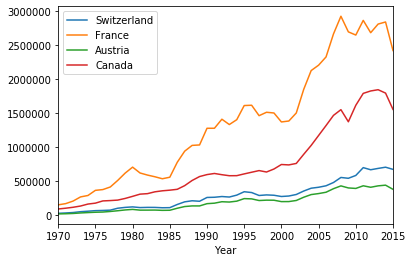

In [12]:
select_switzerland = df_useful["GDP"]['Area']=='Switzerland'
select_france = df_useful["GDP"]['Area']=='France'
select_austria = df_useful["GDP"]['Area']=='Austria'
select_canada = df_useful["GDP"]['Area']=='Canada'
ax = df_useful["GDP"][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

For dissolute or new countries, we have some Nan values (before appearing or after dissolution) as in this next example :

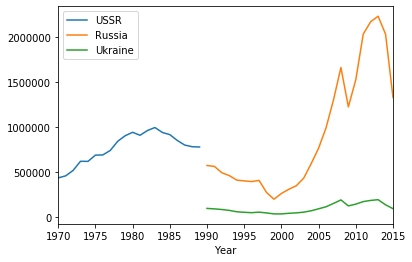

In [13]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.ii. Extracting crops harvested area, production, seed and yield from the "Crops production" dataset<a name="1Daii"></a>
We want to extract crops harvested area, production, seed and yield from the "Crops production" dataset. As all crops are not food crops, we request the [World crops database](https://world-crops.com/food-crops/) to keep only the food crops.

In [14]:
def get_food_crops():
    #Return a list of crops categorized as food crops https://world-crops.com/food-crops/
    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements

def inclusive_search(string,elements):
    #returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results
    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):    
    #extracts the food crop data, returns 4 df: Area,Production,Seed and yield    
    df=df.copy()
    food_crops=list(map(lambda x: x.lower(),get_food_crops()))              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]   
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])
  
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [15]:
df_useful['Crops Area harvested'] = food_crop_area_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Production'] = food_crop_production_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Seed'] = food_crop_seed_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Yield'] =  food_crop_yield_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

We check everything is fine by looking at samples for each of the new dataframes:

In [16]:
display(df_useful['Crops Area harvested'].sample(5))
display(df_useful['Crops Production'].sample(5))
display(df_useful['Crops Seed'].sample(5))
display(df_useful['Crops Yield'].sample(5))

Area Code             Area                   Item  Year Unit  \
212166          21           Brazil                   Yams  1979   ha   
2295908       5400           Europe  Roots and tubers, nes  1977   ha   
1449317        189      Saint Lucia                  Maize  1977   ha   
350686          41  China, mainland                 Barley  1968   ha   
2184279       5301     Central Asia                 Olives  2001   ha   

             Value  
212166     19400.0  
2295908     1017.0  
1449317       50.0  
350686   2246000.0  
2184279      100.0

Area Code                                   Area  \
1733849        226                                 Uganda   
1777917        231               United States of America   
1025195        129                             Madagascar   
1731548        226                                 Uganda   
488765         116  Democratic People's Republic of Korea   

                            Item  Year    Unit      Value  
1733849   Roots and Tubers,Total  1963  tonnes  1855000.0  
1777917                   Millet  1973  tonnes   120000.0  
1025195   Mushrooms and truffles  1982  tonnes        NaN  
1731548                 Tomatoes  1966  tonnes     4500.0  
488765   Onions, shallots, green  1962  tonnes    11000.0

Area Code                              Area  \
495054         250  Democratic Republic of the Congo   
259883         115                          Cambodia   
1295345        168                  Papua New Guinea   
2315134       5401                    Eastern Europe   
2177819       5300                              Asia   

                              Item  Year    Unit       Value  
495054                  Beans, dry  2007  tonnes      7858.0  
259883             Castor oil seed  1963  tonnes       112.0  
1295345                      Maize  1969  tonnes         5.0  
2315134                  Peas, dry  1977  tonnes    493401.0  
2177819  Cereals (Rice Milled Eqv)  1983  tonnes  33632798.0

Area Code            Area              Item  Year   Unit     Value
2230703       5303   Southern Asia  Sugar crops, nes  1967  hg/ha  362903.0
2360642       5404  Western Europe            Apples  2007  hg/ha  405003.0
1735199        230         Ukraine            Carobs  2014  hg/ha   20000.0
1805714        228            USSR             Wheat  1972  hg/ha   13819.0
1138964        143         Morocco       Rice, paddy  1986  hg/ha   45511.0

We also make some plots to have a first understanding of the dataset:

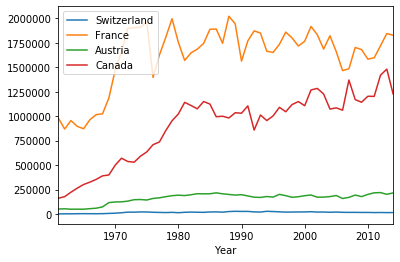

In [17]:
select_Maize = df_useful['Crops Area harvested']['Item']=='Maize'
maize_df = df_useful['Crops Area harvested'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

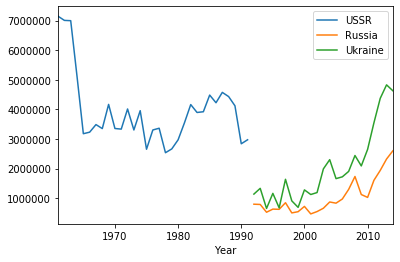

In [18]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iii. Extracting stocks production from the "Livestock production" dataset<a name="1Daiii"></a>

We want to extract stocks production from the "Livestock production" dataset. Again, we drop the columns that are useless for us and have a first look of the data with a sample and some plots.

In [19]:
selection_stocks = df['Livestock production']["Element"] == 'Stocks'
df_useful['Livestock production'] = df['Livestock production'][selection_stocks].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [20]:
display(df_useful['Livestock production'].sample(5))

Area Code             Area             Item  Year       Unit  \
131196       5100           Africa            Ducks  1968  1000 Head   
144490       5303    Southern Asia            Sheep  1983       Head   
138632       5204  Central America           Cattle  1993       Head   
148928       5402  Northern Europe           Cattle  1977       Head   
143777       5302     Eastern Asia  Sheep and Goats  1972       Head   

              Value  
131196       7517.0  
144490  126062608.0  
138632   43109968.0  
148928   27668656.0  
143777  168789422.0

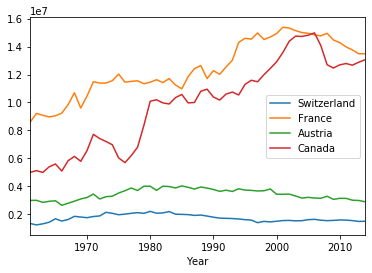

In [21]:
select_pigs = df_useful['Livestock production']['Item']=='Pigs'
pigs_df = df_useful['Livestock production'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

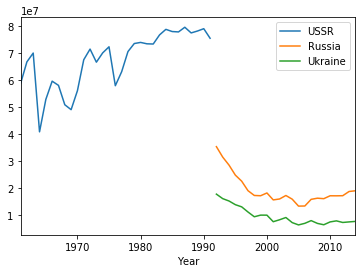

In [22]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iv. Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets<a name="1Daiv"></a>
Now, we extract import and export quantities from the "Live animals trade" and "Crops trade" datasets, having again some samples and some plots.

In [23]:
selection_import_quantities = df['Live animals trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Live animals trade']["Element"] == 'Export Quantity'

df_useful['Live animals import quantities'] = df['Live animals trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Live animals export quantities'] = df['Live animals trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [24]:
display(df_useful['Live animals import quantities'].sample(5))

Area Code            Area              Item  Year  Unit    Value
452103        216        Thailand  Animals live nes  2010  Head      0.0
339357        162          Norway             Goats  2004  Head     26.0
362135        171     Philippines            Cattle  1973  Head     15.0
539061       5101  Eastern Africa   Sheep and Goats  1999  Head  16574.0
596695       5305    Western Asia            Camels  2001  Head  22463.0

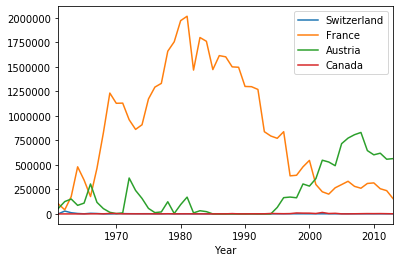

In [25]:
select_pigs = df_useful['Live animals import quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals import quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

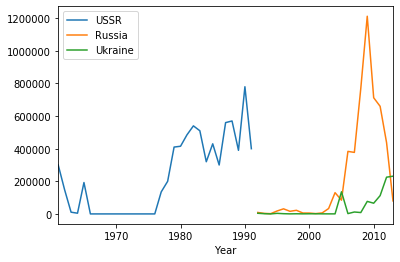

In [26]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [27]:
display(df_useful['Live animals export quantities'].sample(5))

Area Code      Area             Item  Year  Unit     Value
228133        103      Iraq           Horses  1968  Head     475.0
347666        165  Pakistan         Beehives  1973    No       NaN
213833         97   Hungary            Goats  1978  Head    1378.0
262467        119    Latvia            Mules  1993  Head       NaN
163605        238  Ethiopia  Bovine, Animals  2012  Head  205019.0

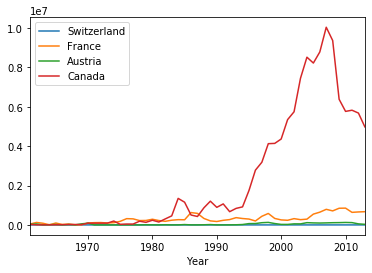

In [28]:
select_pigs = df_useful['Live animals export quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals export quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

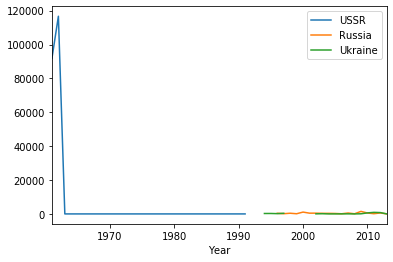

In [29]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [30]:
selection_import_quantities = df['Food trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Food trade']["Element"] == 'Export Quantity'

df_useful['Food import quantities'] = df['Food trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Food export quantities'] = df['Food trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [31]:
display(df_useful['Food import quantities'].sample(5))

Area Code       Area                                    Item  Year  \
13893059       5502  Melanesia                    Oil, coconut (copra)  1973   
439851           10  Australia  Food preparations, flour, malt extract  1994   
7709210         221       Oman                             Oats rolled  1967   
3423324          59      Egypt                        Butter, cow milk  1969   
5384440         106      Italy                                     Tea  1982   

            Unit   Value  
13893059  tonnes    52.0  
439851    tonnes  3287.0  
7709210   tonnes     0.0  
3423324   tonnes   401.0  
5384440   tonnes  3855.0

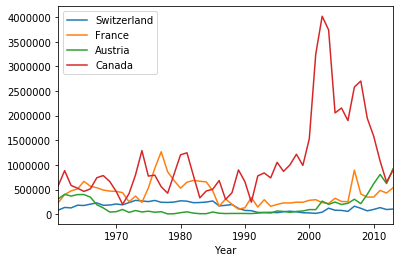

In [32]:
select_Maize = df_useful['Food import quantities']['Item']=='Maize'
maize_df = df_useful['Food import quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

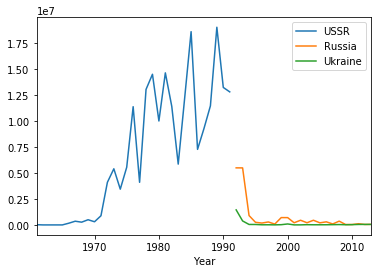

In [33]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [34]:
display(df_useful['Food export quantities'].sample(5))

Area Code       Area               Item  Year    Unit  Value
8235691        173     Poland   Meat Sheep Fresh  2010  tonnes   32.0
403335          22      Aruba    Whey, condensed  1995  tonnes    NaN
4618282         91     Guyana    Rubber, natural  1992  tonnes    NaN
6603592        137  Mauritius        Oil, sesame  2005  tonnes    1.0
5047155        101  Indonesia  Meat Bovine Fresh  1989  tonnes    1.0

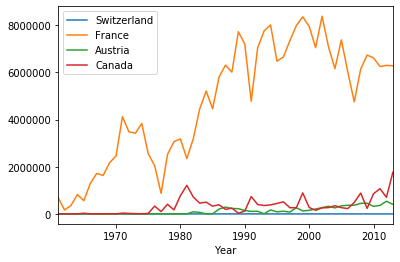

In [35]:
select_Maize = df_useful['Food export quantities']['Item']=='Maize'
maize_df = df_useful['Food export quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

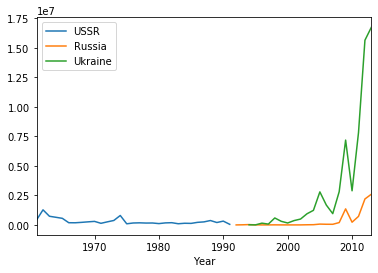

In [36]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.v. Extracting average CPI of each year from the "Consumer price indices" dataset<a name="1Dav"></a>

The "Consumer price indices" dataset contains monthly data. In order to have a uniform dataframe, and as other dataframes have yearly data, we group it by (Country, Year) and compute the mean over the monthes.

In [37]:
df_useful['Consumer price indices'] =  df['Consumer price indices'][['Area',"Year",'Value']] \
                                        .dropna() \
                                        .groupby(['Area',"Year"]) \
                                        .mean() \
                                        .reset_index() \
                                        .dropna()

With samples and plots, we remark that this dataset only start in 2000 wheareas other ones start in 1970.

In [38]:
display(df_useful['Consumer price indices'].sample(5))

Area  Year       Value
2517       Rwanda  2002   49.111154
1467      Ireland  2009  105.356769
1945       Mexico  2003   68.829337
2671      Senegal  2013  108.492254
3     Afghanistan  2007   82.774807

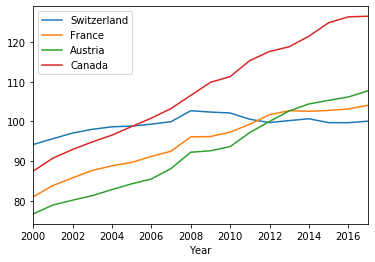

In [39]:
select_switzerland = df_useful['Consumer price indices']['Area']=='Switzerland'
select_france = df_useful['Consumer price indices']['Area']=='France'
select_austria = df_useful['Consumer price indices']['Area']=='Austria'
select_canada = df_useful['Consumer price indices']['Area']=='Canada'
ax = df_useful['Consumer price indices'][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful['Consumer price indices'][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

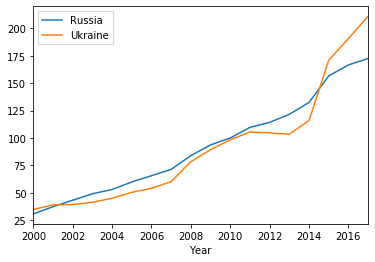

In [40]:
select_russia = df_useful["Consumer price indices"]['Area']=='Russian Federation'
select_ukraine = df_useful["Consumer price indices"]['Area']=='Ukraine'
ax = df_useful["Consumer price indices"][select_russia].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["Consumer price indices"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(['Russia', 'Ukraine'])

##### 1.D.a.vi. Removing areas which are not countries <a name="1Davi"></a>

Having a more detailled look at the dataset, we have remarked that the areas which are real countries are exactely the ones with an "Area Code" below $5000$ but not in $[261, 269]$.

In [41]:
#remove Area code >= 5000 or in [261, 269] (EU)
for df_name in df_useful :
    if 'Area Code' in df_useful[df_name].keys() : 
        print ("Removing areas which are not countries in", df_name)
        selection_countries = df_useful[df_name]['Area Code']<261 
        selection_countries = selection_countries | df_useful[df_name]['Area Code']>269
        selection_countries = selection_countries & df_useful[df_name]['Area Code']<5000
        df_useful[df_name] = df_useful[df_name][selection_countries]
        display(df_useful[df_name].sample(5))
    else :
        print (df_name, "is already clean")

Removing areas which are not countries in GDP


Area Code           Area  Year         Value
433772        201        Somalia  1981  6.678551e+02
126120        279        Curaçao  1970           NaN
184266         79        Germany  2000  1.949952e+06
202023        175  Guinea-Bissau  2015  9.775669e+02
562328       5504      Polynesia  1974  7.239289e+02

Removing areas which are not countries in Crops Area harvested


Area Code                       Area                          Item  \
1688847        222                    Tunisia                      Avocados   
1125861        142                 Montserrat     Cereals (Rice Milled Eqv)   
1840573        243  Wallis and Futuna Islands  Mangoes, mangosteens, guavas   
1609526        211                Switzerland                      Cherries   
46742            8        Antigua and Barbuda  Mangoes, mangosteens, guavas   

         Year Unit  Value  
1688847  1983   ha    NaN  
1125861  1974   ha   10.0  
1840573  1996   ha    2.0  
1609526  1997   ha  350.0  
46742    1983   ha    NaN

Removing areas which are not countries in Crops Production


Area Code             Area                       Item  Year    Unit  \
68657           1          Armenia  Cereals (Rice Milled Eqv)  2003  tonnes   
56063           9        Argentina                     Lupins  1961  tonnes   
840257        103             Iraq                   Apricots  2000  tonnes   
148749         23           Belize              Coffee, green  1991  tonnes   
361276         41  China, mainland                    Papayas  1976  tonnes   

           Value  
68657   309582.0  
56063      300.0  
840257   27000.0  
148749       NaN  
361276       NaN

Removing areas which are not countries in Crops Seed


Area Code                Area      Item  Year    Unit     Value
727276          89           Guatemala  Soybeans  2003  tonnes     520.0
1858721        248        Yugoslav SFR  Soybeans  1987  tonnes    4409.0
2250237       5304  South-Eastern Asia   Sorghum  1970  tonnes     837.0
660302          79             Germany    Barley  1972  tonnes  339776.0
276815          32            Cameroon     Wheat  1994  tonnes      24.0

Removing areas which are not countries in Crops Yield


Area Code                                     Area  \
336112         351                                    China   
2432759       5503                               Micronesia   
2445324       5706                           European Union   
42085            7                                   Angola   
2577394       5817  Net Food Importing Developing Countries   

                         Item  Year   Unit     Value  
336112             Persimmons  2009  hg/ha   40788.0  
2432759  Plantains and others  1984  hg/ha    6000.0  
2445324              Apricots  1983  hg/ha  109294.0  
42085                   Wheat  1986  hg/ha    8000.0  
2577394      Fruit, stone nes  2005  hg/ha   67561.0

Removing areas which are not countries in Livestock production


Area Code                         Area                  Item  Year  \
128840        251                       Zambia  Cattle and Buffaloes  2000   
51703         175                Guinea-Bissau                Horses  1983   
8447           14                     Barbados                 Asses  1970   
121759        215  United Republic of Tanzania       Sheep and Goats  1988   
49999          88                         Guam                  Pigs  2007   

        Unit       Value  
128840  Head   2620987.0  
51703   Head       800.0  
8447    Head      2000.0  
121759  Head  11527647.0  
49999   Head      5200.0

Removing areas which are not countries in Live animals import quantities


Area Code           Area                  Item  Year       Unit  \
515648        261   EU(12)ex.int  Pigeons, other birds  1997  1000 Head   
579939       5300           Asia        Rodents, other  1961  1000 Head   
356785        169       Paraguay                Horses  1976       Head   
76010          29        Burundi                 Mules  1970       Head   
591183       5303  Southern Asia       Sheep and Goats  2001       Head   

          Value  
515648     93.0  
579939      NaN  
356785      0.0  
76010       NaN  
591183  37944.0

Removing areas which are not countries in Live animals export quantities


Area Code                  Area             Item  Year       Unit  \
517229        261          EU(12)ex.int          Turkeys  2000  1000 Head   
100991         96  China, Hong Kong SAR            Goats  1988       Head   
39068          57               Belarus            Goats  2010       Head   
13666           9             Argentina  Camelids, other  2006       Head   
34198          16            Bangladesh            Ducks  1974  1000 Head   

          Value  
517229  14574.0  
100991      0.0  
39068       2.0  
13666       NaN  
34198       NaN

Removing areas which are not countries in Food import quantities


Area Code                               Area                   Item  \
12930745       5302                       Eastern Asia  Meat, chicken, canned   
3986113          70                   French Polynesia  Bananas and plantains   
4509714          89                          Guatemala                Pigmeat   
9790586         209                          Swaziland            Peas, green   
14443542       5815  Low Income Food Deficit Countries             Pineapples   

          Year    Unit  Value  
12930745  1985  tonnes    0.0  
3986113   1996  tonnes    0.0  
4509714   1968  tonnes  166.0  
9790586   1995  tonnes    NaN  
14443542  1962  tonnes    0.0

Removing areas which are not countries in Food export quantities


Area Code            Area                         Item  Year  \
14073398       5706  European Union        Meat, chicken, canned  1984   
9629700          38       Sri Lanka             Wool, hair waste  1997   
10816896        229  United Kingdom         Fixed Vegetable Oils  2006   
3829858          67         Finland  Pumpkins, squash and gourds  1985   
10059952        208      Tajikistan                      Cereals  1999   

            Unit     Value  
14073398  tonnes   55931.0  
9629700   tonnes       NaN  
10816896  tonnes  303868.0  
3829858   tonnes       NaN  
10059952  tonnes       NaN

Consumer price indices is already clean


#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will explain how we will handle the missing data in previous dataframes for maps.

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

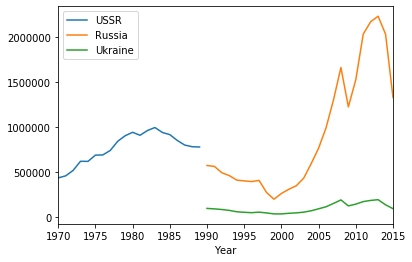

In [42]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In order to vizualize folium maps, we need to associate each country a value. The geojson file that we use is not timestamped and only countries that exist nowadays are inside it. As some countries has been dissolved during the past 50 years, our folium maps won't be complete. For instance, we do not have any value for Ukraine from 1970 to 1989. Our idea to fix this issue is presented in the next paragraph.

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 


Our idea is to map the former country value to each of the current ones. For instance in 1982, USSR GDP is around one trillion $. Therefore, if we associate (only for folium map purposes) this value to each current country that succeeded USSR, all these countries will appear the same color in the folium map, i.e. all the USSR area will appear the same color (and the good one).

In order to do so, one need to identify which countries appeared and disappeared from the dataset and at which year. Then we will use this result along with some historical research in our `visualise_world_data_folium` function ([1Ea](#1Ea)).

In [43]:
countries_formation_years = {}
for country in df_useful["GDP"]["Area"].unique():
    selection = df_useful["GDP"]["Area"] == country
    year_in, year_out = df_useful["GDP"][selection].dropna()["Year"].min(), df_useful["GDP"][selection].dropna()["Year"].max()
    for year in (year_in, year_out):
        if year not in countries_formation_years :
            countries_formation_years[year] = []
    countries_formation_years[year_in].append((country,'+'))
    countries_formation_years[year_out].append((country,'-'))

countries_formation_years.pop(1970)
countries_formation_years.pop(2015)
for year in sorted(list(countries_formation_years)):
    print (year, countries_formation_years[year])

1988 [('Yemen Ar Rp', '-'), ('Yemen Dem', '-')]
1989 [('Czechoslovakia', '-'), ('Ethiopia PDR', '-'), ('USSR', '-'), ('Yemen', '+'), ('Yugoslav SFR', '-')]
1990 [('Armenia', '+'), ('Azerbaijan', '+'), ('Belarus', '+'), ('Bosnia and Herzegovina', '+'), ('Croatia', '+'), ('Czechia', '+'), ('Eritrea', '+'), ('Estonia', '+'), ('Ethiopia', '+'), ('Georgia', '+'), ('Kazakhstan', '+'), ('Kyrgyzstan', '+'), ('Latvia', '+'), ('Lithuania', '+'), ('Montenegro', '+'), ('Republic of Moldova', '+'), ('Russian Federation', '+'), ('Serbia', '+'), ('Slovakia', '+'), ('Slovenia', '+'), ('Tajikistan', '+'), ('The former Yugoslav Republic of Macedonia', '+'), ('Timor-Leste', '+'), ('Turkmenistan', '+'), ('Ukraine', '+'), ('Uzbekistan', '+'), ('Central Asia', '+')]
1999 [('Kosovo', '+')]
2005 [('Curaçao', '+'), ('Sint Maarten (Dutch Part)', '+')]
2007 [('Sudan (former)', '-')]
2008 [('South Sudan', '+'), ('Sudan', '+')]
2012 [('Netherlands Antilles (former)', '-')]


### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>
Some countries have different names in the geojson file and in the dataset. We first start by correcting them.

In [44]:
def correct_country_names(old_name, dic):
    if old_name in dic.keys() :
        return dic[old_name]
    return old_name

In [45]:
dic = {'Czechia': "Czech Republic",
       'Russian Federation':'Russia',
       "Serbia":"Republic of Serbia",
       'The former Yugoslav Republic of Macedonia':'Macedonia',
       'China, mainland':'China',
       'Viet Nam':'Vietnam',
       'Venezuela (Bolivarian Republic of)':'Venezuela',
       'Iran (Islamic Republic of)':'Iran',
       'Syrian Arab Republic':"Syria",
       'Bolivia (Plurinational State of)': 'Bolivia',
       "Côte d'Ivoire": "Ivory Coast",
       'Congo':"Republic of the Congo",
       "Lao People's Democratic Republic":'Laos',
       "Democratic People's Republic of Korea":"North Korea",
       'Republic of Korea':"South Korea"}

for df_name in df_useful :
    print (df_name)
    df_useful[df_name]["Area"] = df_useful[df_name]["Area"].apply(lambda x : correct_country_names(x,dic))

GDP
Crops Area harvested
Crops Production
Crops Seed
Crops Yield
Livestock production
Live animals import quantities
Live animals export quantities
Food import quantities
Food export quantities
Consumer price indices


Then, we do a function that takes as input a dataframe and a year and produces the corresponding folium map. This function also handles dissolutions of countries as suggested [before](#1Dbii).

In [46]:
def visualise_world_data_folium(df, year, logScale=True):
    dic = {'USSR':                            ['Armenia', 'Azerbaijan','Belarus', 'Estonia', 'Georgia',
                                               'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania',
                                               'Montenegro', 'Republic of Moldova', 'Russia',
                                               'Republic of Serbia', 'Timor-Leste', 'Turkmenistan', 'Ukraine',
                                               'Uzbekistan'],
           'Ethiopia PDR':                     ['Eritrea','Ethiopia'],
           'Yugoslav SFR':                     ['Kosovo', 'Slovenia', 'Croatia',
                                                'Macedonia', 'Bosnia and Herzegovina'],
           'Yemen Dem' :                       ['Yemen'],        
           'Czechoslovakia':                   ["Czech Republic", 'Slovakia'],
           'Netherlands Antilles (former)':    ['Curaçao', 'Sint Maarten (Dutch Part)'],
           'Sudan (former)':                   ['South Sudan', 'Sudan']
          }
    to_plot=df[df["Year"]==year]
    to_plot=(to_plot[['Area','Value']]
             .dropna()
             .groupby('Area')             
             .mean()
             .reset_index()
             .dropna()) 
    to_plot['Area']=to_plot['Area'].apply(lambda x : correct_country_names(x, dic))
    to_plot = to_plot.explode('Area')
    if logScale :
        to_plot.Value=np.log10(1+to_plot.Value)
    
    m = folium.Map(location=[40,-10],zoom_start=1.6)
    folium.Choropleth(
        geo_data=f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json",
        data=to_plot,
        columns=['Area', 'Value'],
        key_on='feature.properties.name',
        fill_color='YlGn',fill_opacity=0.7,line_opacity=0.2,nan_fill_opacity=0.0
    ).add_to(m)

    folium.LayerControl().add_to(m)

    return(m)

We can know use it to produce some maps. For instance, we plot below the map of GDP for the year 1985 (before dissolution of USSR) and 1995 (after).

In [47]:
display(visualise_world_data_folium(df_useful["GDP"], 1985, True))
display(visualise_world_data_folium(df_useful["GDP"], 1995, True))

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

Some of our features seem to be right skewed. At first glance it seems that they look like power laws.

For instance the distribution of GDP look a bit like a power law:

C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


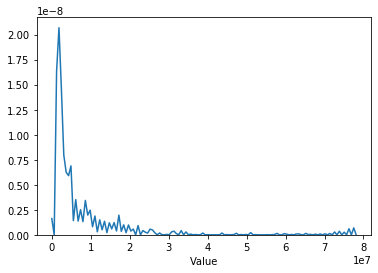

In [48]:
sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

As we later want to train some Machine Learning models, we log those values so that their distribution look a bit more like a normal distribution.

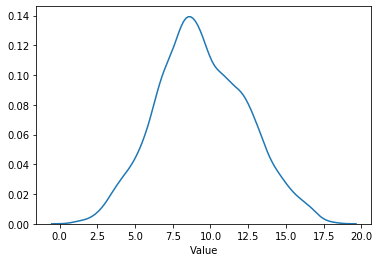

In [49]:
#looks better with log scale
sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

The new distribution indeed looks better to train models on it.

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.


    Country | Year | GDP | Crops production columns | Livestock production columns | Crops importation columns | Livestock importation columns | Crops exportation columns | Livestock exportation columns | CPI
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

The current dataframes have several rows for a given `(Country, Year)`. Each of this row correspond to one item. We would like to have a unique row for a given `(Country, Year)` and one column per item:

In [50]:
need_pivot = ['Crops Area harvested',
              'Crops Production',
              'Crops Seed',
              'Crops Yield',
              'Livestock production',
              'Live animals import quantities',
              'Live animals export quantities',
              'Food import quantities',
              'Food export quantities']

def rename_columns(x, word):
    if x not in ['Area', 'Year', 'ha', 'tonnes', 'hg/ha', 'Head', '1000 Head']:
        return x + ' ' + word
    return x

df_useful['GDP'] = df_useful['GDP'].rename(columns = {'Value':'(GDP, million $)'})[["Area",'Year','(GDP, million $)']]
df_useful['Consumer price indices'] = df_useful['Consumer price indices'].rename(columns = {'Value':'(Consumer price indices, %)'})[["Area",'Year','(Consumer price indices, %)']]

for df_name in need_pivot :
    df_useful[df_name] = pd.pivot_table(df_useful[df_name], index=["Area",'Year'], columns=["Item","Unit"], values="Value").rename(columns=lambda x: rename_columns(x, df_name))
    display(df_useful[df_name].sample(5))

Item                           Anise, badian, fennel, coriander Crops Area harvested  \
Unit                                                                              ha   
Area                      Year                                                         
Saint Pierre and Miquelon 1973                                                NaN      
Georgia                   1999                                                NaN      
Greece                    2000                                              533.0      
Malawi                    1998                                               80.0      
Fiji                      1988                                                NaN      

Item                           Apples Crops Area harvested  \
Unit                                                    ha   
Area                      Year                               
Saint Pierre and Miquelon 1973                         NaN   
Georgia                   1999                     36000.0   
Greece                    2000                     14100.0   
Malawi                    1998                         NaN   
Fiji                      1988                         NaN   

Item                           Apricots Crops Area harvested  \
Unit                                                      ha   
Area                      Year                                 
Saint Pierre and Miquelon 1973                           NaN   
Georgia                   1999                        1200.0   
Greece                    2000                        5500.0   
Malawi                    1998                           NaN   
Fiji                      1988                           NaN   

Item                           Areca nuts Crops Area harvested  \
Unit                                                        ha   
Area                      Year                                   
Saint Pierre and Miquelon 1973                             NaN   
Georgia                   1999                             NaN   
Greece                    2000                             NaN   
Malawi                    1998                             NaN   
Fiji                      1988                             NaN   

Item                           Artichokes Crops Area harvested  \
Unit                                                        ha   
Area                      Year                                   
Saint Pierre and Miquelon 1973                             NaN   
Georgia                   1999                             NaN   
Greece                    2000                          2800.0   
Malawi                    1998                             NaN   
Fiji                      1988                             NaN   

Item                           Asparagus Crops Area harvested  \
Unit                                                       ha   
Area                      Year                                  
Saint Pierre and Miquelon 1973                            NaN   
Georgia                   1999                            NaN   
Greece                    2000                         7300.0   
Malawi                    1998                            NaN   
Fiji                      1988                            NaN   

Item                           Avocados Crops Area harvested  \
Unit                                                      ha   
Area                      Year                                 
Saint Pierre and Miquelon 1973                           NaN   
Georgia                   1999                           NaN   
Greece                    2000                         222.0   
Malawi                    1998                           NaN   
Fiji                      1988                           NaN   

Item                           Bambara beans Crops Area harvested  \
Unit                                                           ha   
Area                      Year                         

Item               Anise, badian, fennel, coriander Crops Production  \
Unit                                                          tonnes   
Area          Year                                                     
Somalia       2012                                               NaN   
Rwanda        1993                                               NaN   
Oman          1996                                               NaN   
Guinea-Bissau 1984                                               NaN   
Montserrat    1969                                               NaN   

Item               Apples Crops Production Apricots Crops Production  \
Unit                                tonnes                    tonnes   
Area          Year                                                     
Somalia       2012                     NaN                       NaN   
Rwanda        1993                     NaN                       NaN   
Oman          1996                     NaN                       NaN   
Guinea-Bissau 1984                     NaN                       NaN   
Montserrat    1969                     NaN                       NaN   

Item               Areca nuts Crops Production Artichokes Crops Production  \
Unit                                    tonnes                      tonnes   
Area          Year                                                           
Somalia       2012                         NaN                         NaN   
Rwanda        1993                         NaN                         NaN   
Oman          1996                         NaN                         NaN   
Guinea-Bissau 1984                         NaN                         NaN   
Montserrat    1969                         NaN                         NaN   

Item               Asparagus Crops Production Avocados Crops Production  \
Unit                                   tonnes                    tonnes   
Area          Year                                                        
Somalia       2012                        NaN                       NaN   
Rwanda        1993                        NaN                       NaN   
Oman          1996                        NaN                       NaN   
Guinea-Bissau 1984                        NaN                       NaN   
Montserrat    1969                        NaN                       NaN   

Item               Bambara beans Crops Production Bananas Crops Production  \
Unit                                       tonnes                   tonnes   
Area          Year                                                           
Somalia       2012                            NaN                  25316.0   
Rwanda        1993                            NaN                2136000.0   
Oman          1996                            NaN                  27000.0   
Guinea-Bissau 1984                            NaN                      NaN   
Montserrat    1969                            NaN                    120.0   

Item               Barley Crops Production  ...  \
Unit                                tonnes  ...   
Area          Year                          ...   
Somalia       2012                     NaN  ...   
Rwanda        1993                     NaN  ...   
Oman          1996                     NaN  ...   
Guinea-Bissau 1984                     NaN  ...   
Montserrat    1969                     NaN  ...   

Item               Sweet potatoes Crops Production  \
Unit                                        tonnes   
Area          Year                                   
Somalia       2012                          8000.0   
Rwanda        1993                        997100.0   
Oman          1996                             NaN   
Guinea-Bissau 1984                             NaN   
Montserrat    1969                            10.0   

Item               Tangerines, mandarins, clementines, satsumas Crops Production  \
Unit                                                                 

Item              Anise, badian, fennel, coriander Crops Seed  \
Unit                                                   tonnes   
Area         Year                                               
Egypt        2012                                         NaN   
Paraguay     1969                                         NaN   
Venezuela    2008                                         NaN   
South Africa 1965                                         NaN   
Turkey       1967                                         NaN   

Item              Bambara beans Crops Seed Bananas Crops Seed  \
Unit                                tonnes             tonnes   
Area         Year                                               
Egypt        2012                      NaN                NaN   
Paraguay     1969                      NaN                NaN   
Venezuela    2008                      NaN                NaN   
South Africa 1965                      NaN                NaN   
Turkey       1967                      NaN                NaN   

Item              Barley Crops Seed Beans, dry Crops Seed  \
Unit                         tonnes                tonnes   
Area         Year                                           
Egypt        2012            7000.0                8000.0   
Paraguay     1969               NaN                3264.0   
Venezuela    2008               NaN                 366.0   
South Africa 1965            4340.0                6500.0   
Turkey       1967          546000.0               10700.0   

Item              Broad beans, horse beans, dry Crops Seed  \
Unit                                                tonnes   
Area         Year                                            
Egypt        2012                                   6000.0   
Paraguay     1969                                    217.0   
Venezuela    2008                                      NaN   
South Africa 1965                                      NaN   
Turkey       1967                                   6600.0   

Item              Buckwheat Crops Seed  \
Unit                            tonnes   
Area         Year                        
Egypt        2012                  NaN   
Paraguay     1969                  NaN   
Venezuela    2008                  NaN   
South Africa 1965                975.0   
Turkey       1967                  NaN   

Item              Cabbages and other brassicas Crops Seed  \
Unit                                               tonnes   
Area         Year                                           
Egypt        2012                                     NaN   
Paraguay     1969                                     NaN   
Venezuela    2008                                     NaN   
South Africa 1965                                     NaN   
Turkey       1967                                     NaN   

Item              Carrots and turnips Crops Seed Cassava Crops Seed  ...  \
Unit                                      tonnes             tonnes  ...   
Area         Year                                                    ...   
Egypt        2012                            NaN                NaN  ...   
Paraguay     1969                            NaN                NaN  ...   
Venezuela    2008                            NaN                NaN  ...   
South Africa 1965                            NaN                NaN  ...   
Turkey       1967                            NaN                NaN  ...   

Item              Sorghum Crops Seed Soybeans Crops Seed  \
Unit                          tonnes              tonnes   
Area         Year                                          
Egypt        2012             5000.0              1000.0   
Paraguay     1969               43.0              1274.0   
Venezuela    2008             5425.0              1650.0   
South Africa 1965             9120.0               315.0   
Turkey       1967                NaN               750.0   

Item              Sugar cane Crops Seed Sweet potatoes C

Item            Anise, badian, fennel, coriander Crops Yield  \
Unit                                                   hg/ha   
Area       Year                                                
Lesotho    1999                                          NaN   
Norway     1990                                          NaN   
Nicaragua  1968                                          NaN   
Mauritania 1961                                          NaN   
Iran       1988                                       7875.0   

Item            Apples Crops Yield Apricots Crops Yield  \
Unit                         hg/ha                hg/ha   
Area       Year                                           
Lesotho    1999                NaN                  NaN   
Norway     1990           103157.0                  NaN   
Nicaragua  1968                NaN                  NaN   
Mauritania 1961                NaN                  NaN   
Iran       1988           101467.0              64326.0   

Item            Areca nuts Crops Yield Artichokes Crops Yield  \
Unit                             hg/ha                  hg/ha   
Area       Year                                                 
Lesotho    1999                    NaN                    NaN   
Norway     1990                    NaN                    NaN   
Nicaragua  1968                    NaN                    NaN   
Mauritania 1961                    NaN                    NaN   
Iran       1988                    NaN                    NaN   

Item            Asparagus Crops Yield Avocados Crops Yield  \
Unit                            hg/ha                hg/ha   
Area       Year                                              
Lesotho    1999                   NaN                  NaN   
Norway     1990                   NaN                  NaN   
Nicaragua  1968                   NaN                  NaN   
Mauritania 1961                   NaN                  NaN   
Iran       1988                   NaN                  NaN   

Item            Bambara beans Crops Yield Bananas Crops Yield  \
Unit                                hg/ha               hg/ha   
Area       Year                                                 
Lesotho    1999                       NaN                 NaN   
Norway     1990                       NaN                 NaN   
Nicaragua  1968                       NaN            331579.0   
Mauritania 1961                       NaN                 NaN   
Iran       1988                       NaN             78090.0   

Item            Barley Crops Yield  ... Sweet potatoes Crops Yield  \
Unit                         hg/ha  ...                      hg/ha   
Area       Year                     ...                              
Lesotho    1999             2601.0  ...                        NaN   
Norway     1990            41507.0  ...                        NaN   
Nicaragua  1968                NaN  ...                        NaN   
Mauritania 1961             6667.0  ...                     9000.0   
Iran       1988            14319.0  ...                        NaN   

Item            Tangerines, mandarins, clementines, satsumas Crops Yield  \
Unit                                                               hg/ha   
Area       Year                                                            
Lesotho    1999                                                NaN         
Norway     1990                                                NaN         
Nicaragua  1968                                                NaN         
Mauritania 1961                                                NaN         
Iran       1988                                           145513.0         

Item            Taro (cocoyam) Crops Yield Tomatoes Crops Yield  \
Unit                                 hg/ha                hg/ha   
Area       Year                                                   
Lesotho    1999                        NaN                  NaN   
Norway     1990                      

Item                  Animals live nes Livestock production  \
Unit                                                   Head   
Area             Year                                         
Israel           1973                                   NaN   
South America    1985                                   NaN   
Guyana           1975                                   NaN   
China, Macao SAR 1994                                   NaN   
Sweden           1981                                   NaN   

Item                  Asses Livestock production  \
Unit                                        Head   
Area             Year                              
Israel           1973                     5800.0   
South America    1985                  3793334.0   
Guyana           1975                     1250.0   
China, Macao SAR 1994                        NaN   
Sweden           1981                        NaN   

Item                  Beehives Livestock production  \
Unit                        No Livestock production   
Area             Year                                 
Israel           1973                       50800.0   
South America    1985                     2848477.0   
Guyana           1975                        3000.0   
China, Macao SAR 1994                           NaN   
Sweden           1981                      180000.0   

Item                  Buffaloes Livestock production  \
Unit                                            Head   
Area             Year                                  
Israel           1973                            NaN   
South America    1985                       882642.0   
Guyana           1975                            NaN   
China, Macao SAR 1994                            NaN   
Sweden           1981                            NaN   

Item                  Camelids, other Livestock production  \
Unit                                                  Head   
Area             Year                                        
Israel           1973                                  NaN   
South America    1985                            5156000.0   
Guyana           1975                                  NaN   
China, Macao SAR 1994                                  NaN   
Sweden           1981                                  NaN   

Item                  Camels Livestock production Cattle Livestock production  \
Unit                                         Head                        Head   
Area             Year                                                           
Israel           1973                     10000.0                    260200.0   
South America    1985                         NaN                 250603216.0   
Guyana           1975                         NaN                    275000.0   
China, Macao SAR 1994                         NaN                         NaN   
Sweden           1981                         NaN                   1938800.0   

Item                  Cattle and Buffaloes Livestock production  \
Unit                                                       Head   
Area             Year                                             
Israel           1973                                  260200.0   
South America    1985                               251485858.0   
Guyana           1975                                  275000.0   
China, Macao SAR 1994                                       NaN   
Sweden           1981                                 1938800.0   

Item                  Chickens Livestock production  \
Unit                                      1000 Head   
Area             Year                                 
Israel           1973                       11439.0   
South America    1985                      775169.0   
Guyana           1975                        9500.0   
China, Macao SAR 1994                         430.0   
Sweden           1981                       12620.0   

Item                  Ducks Livestock production  ...  \
Unit   

Item                                         Animals live nes Live animals import quantities  \
Unit                                                                                    Head   
Area                                    Year                                                   
New Caledonia                           2012                                             0.0   
Philippines                             1983                                             0.0   
Sudan (former)                          1984                                             0.0   
Iraq                                    2007                                             NaN   
Net Food Importing Developing Countries 1975                                             0.0   

Item                                         Asses Live animals import quantities  \
Unit                                                                         Head   
Area                                    Year                                        
New Caledonia                           2012                                  NaN   
Philippines                             1983                                  0.0   
Sudan (former)                          1984                                  0.0   
Iraq                                    2007                                  NaN   
Net Food Importing Developing Countries 1975                                127.0   

Item                                         Beehives Live animals import quantities  \
Unit                                               No Live animals import quantities   
Area                                    Year                                           
New Caledonia                           2012                                     NaN   
Philippines                             1983                                     NaN   
Sudan (former)                          1984                                     NaN   
Iraq                                    2007                                     NaN   
Net Food Importing Developing Countries 1975                                     0.0   

Item                                         Bovine, Animals Live animals import quantities  \
Unit                                                                                   Head   
Area                                    Year                                                  
New Caledonia                           2012                                            0.0   
Philippines                             1983                                            0.0   
Sudan (former)                          1984                                         1560.0   
Iraq                                    2007                                            0.0   
Net Food Importing Developing Countries 1975                                       719305.0   

Item                                         Buffaloes Live animals import quantities  \
Unit                                                                             Head   
Area                                    Year                                            
New Caledonia                           2012                                      NaN   
Philippines                             1983                                      NaN   
Sudan (former)                          1984                                      NaN   
Iraq                                    2007                                      NaN   
Net Food Importing Developing Countries 1975                                  39000.0   

Item                                         Camelids, other Live animals import quantities  \
Unit                                                                                   Head   
Area                                    Year                                                  
New Caledonia                           2012                                          

Item                                  Animals live nes Live animals export quantities  \
Unit                                                                             Head   
Area                             Year                                                   
Yemen                            1988                                             NaN   
Hungary                          1984                                             0.0   
Eastern Europe                   2008                                             0.0   
Central America                  2012                                             0.0   
Saint Vincent and the Grenadines 1971                                             NaN   

Item                                  Asses Live animals export quantities  \
Unit                                                                  Head   
Area                             Year                                        
Yemen                            1988                                  NaN   
Hungary                          1984                                  NaN   
Eastern Europe                   2008                               1797.0   
Central America                  2012                                  1.0   
Saint Vincent and the Grenadines 1971                                  0.0   

Item                                  Beehives Live animals export quantities  \
Unit                                        No Live animals export quantities   
Area                             Year                                           
Yemen                            1988                                     NaN   
Hungary                          1984                                     NaN   
Eastern Europe                   2008                                     NaN   
Central America                  2012                                     2.0   
Saint Vincent and the Grenadines 1971                                     NaN   

Item                                  Bovine, Animals Live animals export quantities  \
Unit                                                                            Head   
Area                             Year                                                  
Yemen                            1988                                            0.0   
Hungary                          1984                                       208619.0   
Eastern Europe                   2008                                      1073842.0   
Central America                  2012                                      1584810.0   
Saint Vincent and the Grenadines 1971                                            NaN   

Item                                  Buffaloes Live animals export quantities  \
Unit                                                                      Head   
Area                             Year                                            
Yemen                            1988                                      NaN   
Hungary                          1984                                      NaN   
Eastern Europe                   2008                                      NaN   
Central America                  2012                                    204.0   
Saint Vincent and the Grenadines 1971                                      NaN   

Item                                  Camelids, other Live animals export quantities  \
Unit                                                                            Head   
Area                             Year                                                  
Yemen                            1988                                            NaN   
Hungary                          1984                                            NaN   
Eastern Europe                   2008                                            NaN   
Central America                  2012                                            NaN   
Saint Vincent and the Grenadines 19

Item                     Alfalfa meal and pellets Food import quantities  \
Unit                                                              tonnes   
Area                Year                                                   
Trinidad and Tobago 1962                                             NaN   
Western Europe      2000                                        301439.0   
Eastern Europe      2008                                         10408.0   
Northern Africa     1975                                             0.0   
Jordan              1994                                             0.0   

Item                     Almonds shelled Food import quantities  \
Unit                                                     tonnes   
Area                Year                                          
Trinidad and Tobago 1962                                    0.0   
Western Europe      2000                               112272.0   
Eastern Europe      2008                                24244.0   
Northern Africa     1975                                  190.0   
Jordan              1994                                  126.0   

Item                     Animal Oil+Fat+Grs Food import quantities  \
Unit                                                        tonnes   
Area                Year                                             
Trinidad and Tobago 1962                                    2037.0   
Western Europe      2000                                  426506.0   
Eastern Europe      2008                                  415419.0   
Northern Africa     1975                                  178670.0   
Jordan              1994                                    6584.0   

Item                     Animal Vegetable Oil Food import quantities  \
Unit                                                          tonnes   
Area                Year                                               
Trinidad and Tobago 1962                                      3995.0   
Western Europe      2000                                   7199466.0   
Eastern Europe      2008                                   3432103.0   
Northern Africa     1975                                    871422.0   
Jordan              1994                                    212245.0   

Item                     Animal fats Food import quantities  \
Unit                                                 tonnes   
Area                Year                                      
Trinidad and Tobago 1962                             2037.0   
Western Europe      2000                           426506.0   
Eastern Europe      2008                           415419.0   
Northern Africa     1975                           178670.0   
Jordan              1994                             6584.0   

Item                     Anise, badian, fennel, coriander Food import quantities  \
Unit                                                                      tonnes   
Area                Year                                                           
Trinidad and Tobago 1962                                                0.0        
Western Europe      2000                                            25956.0        
Eastern Europe      2008                                             6218.0        
Northern Africa     1975                                             1922.0        
Jordan              1994                                              965.0        

Item                     Apples Food import quantities  \
Unit                                            tonnes   
Area                Year                                 
Trinidad and Tobago 1962                         880.0   
Western Europe      2000                     1456489.0   
Eastern Europe      2008                     1533167.0   
Northern Africa     1975                       25970.0   
Jordan              1994                        2752.0   

Item                     Apricots Food import quantities  \
Unit         

Item          Alfalfa meal and pellets Food export quantities  \
Unit                                                   tonnes   
Area     Year                                                   
Germany  1992                                            77.0   
Niue     1967                                             NaN   
Thailand 1969                                             0.0   
Jamaica  1989                                             NaN   
Europe   1982                                        280033.0   

Item          Almonds shelled Food export quantities  \
Unit                                          tonnes   
Area     Year                                          
Germany  1992                                 3942.0   
Niue     1967                                    NaN   
Thailand 1969                                    NaN   
Jamaica  1989                                    NaN   
Europe   1982                                49870.0   

Item          Animal Oil+Fat+Grs Food export quantities  \
Unit                                             tonnes   
Area     Year                                             
Germany  1992                                  153458.0   
Niue     1967                                       NaN   
Thailand 1969                                      87.0   
Jamaica  1989                                       0.0   
Europe   1982                                  521990.0   

Item          Animal Vegetable Oil Food export quantities  \
Unit                                               tonnes   
Area     Year                                               
Germany  1992                                   1762276.0   
Niue     1967                                         0.0   
Thailand 1969                                       538.0   
Jamaica  1989                                         5.0   
Europe   1982                                   5077923.0   

Item          Animal fats Food export quantities  \
Unit                                      tonnes   
Area     Year                                      
Germany  1992                           153458.0   
Niue     1967                                NaN   
Thailand 1969                               87.0   
Jamaica  1989                                0.0   
Europe   1982                           521990.0   

Item          Anise, badian, fennel, coriander Food export quantities  \
Unit                                                           tonnes   
Area     Year                                                           
Germany  1992                                             1599.0        
Niue     1967                                                NaN        
Thailand 1969                                                0.0        
Jamaica  1989                                                0.0        
Europe   1982                                            12704.0        

Item          Apples Food export quantities Apricots Food export quantities  \
Unit                                 tonnes                          tonnes   
Area     Year                                                                 
Germany  1992                       41537.0                           959.0   
Niue     1967                           NaN                             NaN   
Thailand 1969                           0.0                             NaN   
Jamaica  1989                           NaN                             NaN   
Europe   1982                     1969237.0                         71519.0   

Item          Apricots, dry Food export quantities  \
Unit                                        tonnes   
Area     Year                                        
Germany  1992                                759.0   
Niue     1967                                  NaN   
Thailand 1969                                  NaN   
Jamaica  1989                                  NaN   
Europe   1982                               1486.0   



Some Nan values have appeared. As we have datasets that have great outliers, we would replace those Nan values by the median of the column:

In [51]:
# Deal with the NaN that appeared
for df_name in df_useful :
    if df_name != "GDP":
        for column in list(df_useful[df_name]):
            if column not in ['Area', 'Year']:
                df_useful[df_name][column].fillna(0, inplace=True)

In [52]:
#removing the multiindex, so that merge is clean with GDP and CPI
for df_name in need_pivot :
    df_useful[df_name].columns = [' '.join([str(_) for _ in v]) for v in df_useful[df_name].columns.values]
    display(df_useful[df_name].sample(5))
    

Anise, badian, fennel, coriander Crops Area harvested ha  \
Area                     Year                                                             
Central African Republic 2001                                                0.0          
El Salvador              1992                                                0.0          
Myanmar                  1975                                                0.0          
Bulgaria                 1962                                             1845.0          
Guam                     1988                                                0.0          

                               Apples Crops Area harvested ha  \
Area                     Year                                   
Central African Republic 2001                             0.0   
El Salvador              1992                             0.0   
Myanmar                  1975                             0.0   
Bulgaria                 1962                         21443.0   
Guam                     1988                             0.0   

                               Apricots Crops Area harvested ha  \
Area                     Year                                     
Central African Republic 2001                               0.0   
El Salvador              1992                               0.0   
Myanmar                  1975                               0.0   
Bulgaria                 1962                            4821.0   
Guam                     1988                               0.0   

                               Areca nuts Crops Area harvested ha  \
Area                     Year                                       
Central African Republic 2001                                 0.0   
El Salvador              1992                                 0.0   
Myanmar                  1975                             26000.0   
Bulgaria                 1962                                 0.0   
Guam                     1988                                 0.0   

                               Artichokes Crops Area harvested ha  \
Area                     Year                                       
Central African Republic 2001                                 0.0   
El Salvador              1992                                 0.0   
Myanmar                  1975                                 0.0   
Bulgaria                 1962                                 0.0   
Guam                     1988                                 0.0   

                               Asparagus Crops Area harvested ha  \
Area                     Year                                      
Central African Republic 2001                                0.0   
El Salvador              1992                                0.0   
Myanmar                  1975                                0.0   
Bulgaria                 1962                                0.0   
Guam                     1988                                0.0   

                               Avocados Crops Area harvested ha  \
Area                     Year                                     
Central African Republic 2001                             736.0   
El Salvador              1992                            4000.0   
Myanmar                  1975                               0.0   
Bulgaria                 1962                               0.0   
Guam                     1988                               0.0   

                               Bambara beans Crops Area harvested ha  \
Area                     Year                                          
Central African Republic 2001                                    0.0   
El Salvador              1992                                    0.0   
Myanmar                  1975                                    0.0   
Bulgaria                 1962                                    0.0   
Guam                     1988                                    0.0   

                               Bananas Crops Ar

Anise, badian, fennel, coriander Crops Production tonnes  \
Area                      Year                                                             
Bhutan                    1982                                                0.0          
Wallis and Futuna Islands 1962                                                0.0          
Greece                    2000                                              525.0          
Guatemala                 1992                                              570.0          
Romania                   1985                                                0.0          

                                Apples Crops Production tonnes  \
Area                      Year                                   
Bhutan                    1982                          3345.0   
Wallis and Futuna Islands 1962                             0.0   
Greece                    2000                        314510.0   
Guatemala                 1992                         27181.0   
Romania                   1985                        699100.0   

                                Apricots Crops Production tonnes  \
Area                      Year                                     
Bhutan                    1982                               0.0   
Wallis and Futuna Islands 1962                               0.0   
Greece                    2000                           83634.0   
Guatemala                 1992                               0.0   
Romania                   1985                           42500.0   

                                Areca nuts Crops Production tonnes  \
Area                      Year                                       
Bhutan                    1982                                 0.0   
Wallis and Futuna Islands 1962                                 0.0   
Greece                    2000                                 0.0   
Guatemala                 1992                                 0.0   
Romania                   1985                                 0.0   

                                Artichokes Crops Production tonnes  \
Area                      Year                                       
Bhutan                    1982                                 0.0   
Wallis and Futuna Islands 1962                                 0.0   
Greece                    2000                             31000.0   
Guatemala                 1992                                 0.0   
Romania                   1985                                 0.0   

                                Asparagus Crops Production tonnes  \
Area                      Year                                      
Bhutan                    1982                                0.0   
Wallis and Futuna Islands 1962                                0.0   
Greece                    2000                            29000.0   
Guatemala                 1992                                0.0   
Romania                   1985                                0.0   

                                Avocados Crops Production tonnes  \
Area                      Year                                     
Bhutan                    1982                               0.0   
Wallis and Futuna Islands 1962                               0.0   
Greece                    2000                            1259.0   
Guatemala                 1992                           22477.0   
Romania                   1985                               0.0   

                                Bambara beans Crops Production tonnes  \
Area                      Year                                          
Bhutan                    1982                                    0.0   
Wallis and Futuna Islands 1962                                    0.0   
Greece                    2000                                    0.0   
Guatemala                 1992                                    0.0   
Romania                   1985                                    

Anise, badian, fennel, coriander Crops Seed tonnes  \
Area                             Year                                                       
United Kingdom                   2002                                                0.0    
Ghana                            2008                                                0.0    
Saint Vincent and the Grenadines 2007                                                0.0    
Wallis and Futuna Islands        1993                                                0.0    
Barbados                         1962                                                0.0    

                                       Bambara beans Crops Seed tonnes  \
Area                             Year                                    
United Kingdom                   2002                              0.0   
Ghana                            2008                              0.0   
Saint Vincent and the Grenadines 2007                              0.0   
Wallis and Futuna Islands        1993                              0.0   
Barbados                         1962                              0.0   

                                       Bananas Crops Seed tonnes  \
Area                             Year                              
United Kingdom                   2002                        0.0   
Ghana                            2008                        0.0   
Saint Vincent and the Grenadines 2007                        0.0   
Wallis and Futuna Islands        1993                        0.0   
Barbados                         1962                        0.0   

                                       Barley Crops Seed tonnes  \
Area                             Year                             
United Kingdom                   2002                  162000.0   
Ghana                            2008                       0.0   
Saint Vincent and the Grenadines 2007                       0.0   
Wallis and Futuna Islands        1993                       0.0   
Barbados                         1962                       0.0   

                                       Beans, dry Crops Seed tonnes  \
Area                             Year                                 
United Kingdom                   2002                           0.0   
Ghana                            2008                           0.0   
Saint Vincent and the Grenadines 2007                           0.0   
Wallis and Futuna Islands        1993                           0.0   
Barbados                         1962                           0.0   

                                       Broad beans, horse beans, dry Crops Seed tonnes  \
Area                             Year                                                    
United Kingdom                   2002                                              0.0   
Ghana                            2008                                              0.0   
Saint Vincent and the Grenadines 2007                                              0.0   
Wallis and Futuna Islands        1993                                              0.0   
Barbados                         1962                                              0.0   

                                       Buckwheat Crops Seed tonnes  \
Area                             Year                                
United Kingdom                   2002                          0.0   
Ghana                            2008                          0.0   
Saint Vincent and the Grenadines 2007                          0.0   
Wallis and Futuna Islands        1993                          0.0   
Barbados                         1962                          0.0   

                                       Cabbages and other brassicas Crops Seed tonnes  \
Area                             Year                                                   
United Kingdom                   2002                                             0.0   
Ghana                            2

Anise, badian, fennel, coriander Crops Yield hg/ha  \
Area    Year                                                       
Ukraine 2002                                            12500.0    
Israel  2010                                                0.0    
Ecuador 1999                                             4800.0    
Bahrain 1967                                                0.0    
Guam    2013                                                0.0    

              Apples Crops Yield hg/ha  Apricots Crops Yield hg/ha  \
Area    Year                                                         
Ukraine 2002                   27062.0                     65238.0   
Israel  2010                  451801.0                    108005.0   
Ecuador 1999                   56174.0                     45367.0   
Bahrain 1967                       0.0                         0.0   
Guam    2013                       0.0                         0.0   

              Areca nuts Crops Yield hg/ha  Artichokes Crops Yield hg/ha  \
Area    Year                                                               
Ukraine 2002                           0.0                           0.0   
Israel  2010                           0.0                     1648524.0   
Ecuador 1999                           0.0                           0.0   
Bahrain 1967                           0.0                           0.0   
Guam    2013                           0.0                           0.0   

              Asparagus Crops Yield hg/ha  Avocados Crops Yield hg/ha  \
Area    Year                                                            
Ukraine 2002                          0.0                         0.0   
Israel  2010                      40693.0                    105933.0   
Ecuador 1999                      28102.0                     79175.0   
Bahrain 1967                          0.0                         0.0   
Guam    2013                          0.0                         0.0   

              Bambara beans Crops Yield hg/ha  Bananas Crops Yield hg/ha  \
Area    Year                                                               
Ukraine 2002                              0.0                        0.0   
Israel  2010                              0.0                   448168.0   
Ecuador 1999                              0.0                   330165.0   
Bahrain 1967                              0.0                   100000.0   
Guam    2013                              0.0                   232389.0   

              Barley Crops Yield hg/ha  ...  Sweet potatoes Crops Yield hg/ha  \
Area    Year                            ...                                     
Ukraine 2002                   24957.0  ...                               0.0   
Israel  2010                    8277.0  ...                          259387.0   
Ecuador 1999                    6961.0  ...                           56766.0   
Bahrain 1967                       0.0  ...                          200000.0   
Guam    2013                       0.0  ...                           73529.0   

              Tangerines, mandarins, clementines, satsumas Crops Yield hg/ha  \
Area    Year                                                                   
Ukraine 2002                                                0.0                
Israel  2010                                           226000.0                
Ecuador 1999                                             9323.0                
Bahrain 1967                                                0.0                
Guam    2013                                                0.0                

              Taro (cocoyam) Crops Yield hg/ha  Tomatoes Crops Yield hg/ha  \
Area    Year                                                                 
Ukraine 2002                               0.0                    115712.0   
Israel  2010                               0.0                    777941.0   
Ecuador 1999               

Animals live nes Livestock production Head  \
Area              Year                                               
Equatorial Guinea 2012                                         0.0   
France            1991                                         0.0   
Western Africa    1976                                         0.0   
Guinea-Bissau     1998                                         0.0   
Northern Europe   2003                                         0.0   

                        Asses Livestock production Head  \
Area              Year                                    
Equatorial Guinea 2012                              0.0   
France            1991                          20000.0   
Western Africa    1976                        2793232.0   
Guinea-Bissau     1998                           4900.0   
Northern Europe   2003                           5200.0   

                        Beehives Livestock production No Livestock production  \
Area              Year                                                          
Equatorial Guinea 2012                                                0.0       
France            1991                                          1123870.0       
Western Africa    1976                                            48000.0       
Guinea-Bissau     1998                                             6100.0       
Northern Europe   2003                                           222467.0       

                        Buffaloes Livestock production Head  \
Area              Year                                        
Equatorial Guinea 2012                                  0.0   
France            1991                                  0.0   
Western Africa    1976                                  0.0   
Guinea-Bissau     1998                                  0.0   
Northern Europe   2003                                  0.0   

                        Camelids, other Livestock production Head  \
Area              Year                                              
Equatorial Guinea 2012                                        0.0   
France            1991                                        0.0   
Western Africa    1976                                        0.0   
Guinea-Bissau     1998                                        0.0   
Northern Europe   2003                                        0.0   

                        Camels Livestock production Head  \
Area              Year                                     
Equatorial Guinea 2012                               0.0   
France            1991                               0.0   
Western Africa    1976                         1972060.0   
Guinea-Bissau     1998                               0.0   
Northern Europe   2003                               0.0   

                        Cattle Livestock production Head  \
Area              Year                                     
Equatorial Guinea 2012                            5300.0   
France            1991                        21450496.0   
Western Africa    1976                        29323122.0   
Guinea-Bissau     1998                          487360.0   
Northern Europe   2003                        24293818.0   

                        Cattle and Buffaloes Livestock production Head  \
Area              Year                                                   
Equatorial Guinea 2012                                          5300.0   
France            1991                                      21450496.0   
Western Africa    1976                                      29323122.0   
Guinea-Bissau     1998                                        487360.0   
Northern Europe   2003                                      24293818.0   

                        Chickens Livestock production 1000 Head  \
Area              Year                                            
Equatorial Guinea 2012                                    355.0   
France            1991                                 198943.0

Animals live nes Live animals import quantities Head  \
Area                  Year                                                         
French Polynesia      2004                                                0.0      
Republic of the Congo 1973                                                0.0      
Georgia               2003                                                0.0      
Suriname              2008                                                0.0      
Sri Lanka             1983                                                0.0      

                            Asses Live animals import quantities Head  \
Area                  Year                                              
French Polynesia      2004                                        0.0   
Republic of the Congo 1973                                        0.0   
Georgia               2003                                        0.0   
Suriname              2008                                        0.0   
Sri Lanka             1983                                        0.0   

                            Beehives Live animals import quantities No Live animals import quantities  \
Area                  Year                                                                              
French Polynesia      2004                                                0.0                           
Republic of the Congo 1973                                                0.0                           
Georgia               2003                                                0.0                           
Suriname              2008                                                0.0                           
Sri Lanka             1983                                                0.0                           

                            Bovine, Animals Live animals import quantities Head  \
Area                  Year                                                        
French Polynesia      2004                                               12.0     
Republic of the Congo 1973                                             4000.0     
Georgia               2003                                              382.0     
Suriname              2008                                                0.0     
Sri Lanka             1983                                                0.0     

                            Buffaloes Live animals import quantities Head  \
Area                  Year                                                  
French Polynesia      2004                                            0.0   
Republic of the Congo 1973                                            0.0   
Georgia               2003                                            0.0   
Suriname              2008                                            0.0   
Sri Lanka             1983                                            0.0   

                            Camelids, other Live animals import quantities Head  \
Area                  Year                                                        
French Polynesia      2004                                                0.0     
Republic of the Congo 1973                                                0.0     
Georgia               2003                                                0.0     
Suriname              2008                                                0.0     
Sri Lanka             1983                                                0.0     

                            Camels Live animals import quantities Head  \
Area                  Year                                               
French Polynesia      2004                                         0.0   
Republic of the Congo 1973                                         0.0   
Georgia               2003                                         0.0   
Suriname              2008                                         0.0   
Sri Lanka             1983                 

Animals live nes Live animals export quantities Head  \
Area                             Year                                                         
Central America                  1990                                                0.0      
European Union (exc intra-trade) 2012                                               40.0      
Americas                         1983                                                0.0      
Burkina Faso                     2009                                                0.0      
Dominica                         2009                                                0.0      

                                       Asses Live animals export quantities Head  \
Area                             Year                                              
Central America                  1990                                      711.0   
European Union (exc intra-trade) 2012                                       26.0   
Americas                         1983                                        0.0   
Burkina Faso                     2009                                        0.0   
Dominica                         2009                                        0.0   

                                       Beehives Live animals export quantities No Live animals export quantities  \
Area                             Year                                                                              
Central America                  1990                                                0.0                           
European Union (exc intra-trade) 2012                                               17.0                           
Americas                         1983                                                0.0                           
Burkina Faso                     2009                                                0.0                           
Dominica                         2009                                                0.0                           

                                       Bovine, Animals Live animals export quantities Head  \
Area                             Year                                                        
Central America                  1990                                          1358204.0     
European Union (exc intra-trade) 2012                                           677623.0     
Americas                         1983                                          1157035.0     
Burkina Faso                     2009                                            66046.0     
Dominica                         2009                                                0.0     

                                       Buffaloes Live animals export quantities Head  \
Area                             Year                                                  
Central America                  1990                                            0.0   
European Union (exc intra-trade) 2012                                          180.0   
Americas                         1983                                         1245.0   
Burkina Faso                     2009                                            0.0   
Dominica                         2009                                            0.0   

                                       Camelids, other Live animals export quantities Head  \
Area                             Year                                                        
Central America                  1990                                                0.0     
European Union (exc intra-trade) 2012                                                4.0     
Americas                         1983                                                0.0     
Burkina Faso                     2009                                                0.0     
Dominica                         2009                                                0.0     

                                    

Alfalfa meal and pellets Food import quantities tonnes  \
Area         Year                                                           
Iraq         1968                                                0.0        
EU(15)ex.int 2001                                             2163.0        
Finland      2013                                             1570.0        
Suriname     1987                                                0.0        
Iran         2009                                                0.0        

                   Almonds shelled Food import quantities tonnes  \
Area         Year                                                  
Iraq         1968                                            0.0   
EU(15)ex.int 2001                                       128738.0   
Finland      2013                                          931.0   
Suriname     1987                                            0.0   
Iran         2009                                            0.0   

                   Animal Oil+Fat+Grs Food import quantities tonnes  \
Area         Year                                                     
Iraq         1968                                            1469.0   
EU(15)ex.int 2001                                          161618.0   
Finland      2013                                           23613.0   
Suriname     1987                                               0.0   
Iran         2009                                            1048.0   

                   Animal Vegetable Oil Food import quantities tonnes  \
Area         Year                                                       
Iraq         1968                                            56219.0    
EU(15)ex.int 2001                                          5683240.0    
Finland      2013                                           153826.0    
Suriname     1987                                             3300.0    
Iran         2009                                          1067591.0    

                   Animal fats Food import quantities tonnes  \
Area         Year                                              
Iraq         1968                                     1469.0   
EU(15)ex.int 2001                                   161618.0   
Finland      2013                                    23613.0   
Suriname     1987                                        0.0   
Iran         2009                                     1048.0   

                   Anise, badian, fennel, coriander Food import quantities tonnes  \
Area         Year                                                                   
Iraq         1968                                              134.0                
EU(15)ex.int 2001                                            24646.0                
Finland      2013                                              113.0                
Suriname     1987                                                0.0                
Iran         2009                                             1779.0                

                   Apples Food import quantities tonnes  \
Area         Year                                         
Iraq         1968                               32133.0   
EU(15)ex.int 2001                              732978.0   
Finland      2013                               44576.0   
Suriname     1987                                   0.0   
Iran         2009                               12199.0   

                   Apricots Food import quantities tonnes  \
Area         Year                                           
Iraq         1968                                     0.0   
EU(15)ex.int 2001                                 12113.0   
Finland      2013                                   526.0   
Suriname     1987                                     0.0   
Iran         2009                                     0.0   

                   Apricots, dry Food import quantities tonnes  \
Area         Year                      

Alfalfa meal and pellets Food export quantities tonnes  \
Area                   Year                                                           
Bulgaria               1963                                                0.0        
Europe                 1989                                           519921.0        
British Virgin Islands 1991                                                0.0        
Brunei Darussalam      2000                                                0.0        
Niue                   1987                                                0.0        

                             Almonds shelled Food export quantities tonnes  \
Area                   Year                                                  
Bulgaria               1963                                            0.0   
Europe                 1989                                        44452.0   
British Virgin Islands 1991                                            0.0   
Brunei Darussalam      2000                                            0.0   
Niue                   1987                                            0.0   

                             Animal Oil+Fat+Grs Food export quantities tonnes  \
Area                   Year                                                     
Bulgaria               1963                                             862.0   
Europe                 1989                                          798953.0   
British Virgin Islands 1991                                               0.0   
Brunei Darussalam      2000                                               0.0   
Niue                   1987                                               0.0   

                             Animal Vegetable Oil Food export quantities tonnes  \
Area                   Year                                                       
Bulgaria               1963                                            17545.0    
Europe                 1989                                          7210663.0    
British Virgin Islands 1991                                                0.0    
Brunei Darussalam      2000                                                0.0    
Niue                   1987                                                0.0    

                             Animal fats Food export quantities tonnes  \
Area                   Year                                              
Bulgaria               1963                                      862.0   
Europe                 1989                                   798953.0   
British Virgin Islands 1991                                        0.0   
Brunei Darussalam      2000                                        0.0   
Niue                   1987                                        0.0   

                             Anise, badian, fennel, coriander Food export quantities tonnes  \
Area                   Year                                                                   
Bulgaria               1963                                              931.0                
Europe                 1989                                            15701.0                
British Virgin Islands 1991                                                0.0                
Brunei Darussalam      2000                                                0.0                
Niue                   1987                                                0.0                

                             Apples Food export quantities tonnes  \
Area                   Year                                         
Bulgaria               1963                               41718.0   
Europe                 1989                             1927965.0   
British Virgin Islands 1991                                   0.0   
Brunei Darussalam      2000                                   0.0   
Niue                   1987                                   0.0   

                             Apricots Food export qua

#### 1.F.b. Merging everything  <a name="1Fb"></a>
We are now creating the uniformized dataframe `uni_df`. Each row corresponds to one tuple `(Country, Year)` so that we can later group by country or year. In addition to the country ("Area") and the "Year", the columns will either be an economic feature ("GDP", "CPI") or an agricultural one (some crop harvested area, some livestock export quantity, ...)

In [53]:
uni_df = df_useful['GDP'].dropna()
for df_name in need_pivot :
    uni_df = pd.merge(uni_df, df_useful[df_name], how='left', on=['Area', 'Year'])
uni_df = pd.merge(uni_df,df_useful['Consumer price indices'], how='left', on=['Area', 'Year'])

# Deal with the NaN that appeared
for column in list(uni_df):
    if column not in ['Area', 'Year']:
        uni_df[column].fillna(0, inplace=True)
uni_df.sample(30)

Area  Year  (GDP, million $)  \
1149                            Brazil  2003      5.589221e+05   
9350                     Middle Africa  1986      3.640911e+04   
3928                              Iran  1994      1.143748e+05   
9738                     South America  2006      2.025012e+06   
1350                           Burundi  1974      3.455695e+02   
6024                         Nicaragua  2014      1.179022e+04   
731                           Barbados  2005      3.897300e+03   
2813                 Equatorial Guinea  2015      1.381173e+04   
4768                     Liechtenstein  2003      3.430954e+03   
9061                       Yemen Ar Rp  1985      2.324290e+03   
4420                            Kuwait  1983      2.086960e+04   
9866                     Southern Asia  1970      9.562278e+04   
7141                        San Marino  1975      1.602854e+02   
9607                  Northern America  2013      1.854220e+07   
7673                      South Africa  2004      2.285903e+05   
5340  Micronesia (Federated States of)  1997      2.067319e+02   
7365                        Seychelles  1989      3.683086e+02   
9100                      Yugoslav SFR  1986      7.937065e+04   
3783                           Iceland  1987      5.565386e+03   
7667                      South Africa  1998      1.399130e+05   
8497                            Tuvalu  1980      4.296581e+00   
4910                            Malawi  1981      2.236402e+03   
3472                         Guatemala  1998      1.728995e+04   
6930                            Rwanda  1994      1.141601e+03   
7270                      Saudi Arabia  2012      7.339558e+05   
6608                            Poland  2000      1.718866e+05   
487                            Austria  1971      1.781573e+04   
6301                          Pakistan  2015      2.664583e+05   
6471                          Paraguay  2001      6.445725e+03   
349                          Argentina  1997      3.175326e+05   

      Anise, badian, fennel, coriander Crops Area harvested ha  \
1149                                                0.0          
9350                                                0.0          
3928                                            35000.0          
9738                                             4680.0          
1350                                                0.0          
6024                                                0.0          
731                                                 0.0          
2813                                                0.0          
4768                                                0.0          
9061                                                0.0          
4420                                                0.0          
9866                                           108000.0          
7141                                                0.0          
9607                                            13119.0          
7673                                                0.0          
5340                                                0.0          
7365                                                0.0          
9100                                             2100.0          
3783                                                0.0          
7667                                                0.0          
8497                                                0.0          
4910                                                0.0          
3472                                              871.0          
6930                                                0.0          
7270                                                0.0          
6608                                                0.0          
487                                                 0.0          
6301                                                0.0          
6471                                                0.0          
349    

### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)      
                
    3. [Structure of international trade and historical context](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Consumer price indices](#2B), then study the [structure of international trade and historical context](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)

##### 2.A.a Crops and livestock production and trade <a name="2Aa"></a>
TODO

##### 2.A.b Introducing the concept of food self-sufficiency <a name="2Ab"></a>
In this section we will present and compute the notion of food self-sufficiency.
###### 2.A.b.i Basic idea <a name="2Abi"></a>
One may wonder how to know whether a country produce all the food it needs or not. The notion of food-self-sufficency allows to answer to this question. More formally, it is a rate that decribes how much does a country can satisfy to meet its internal consumption needs by production. It describes the extent to which a country is able to feed its population through its domestic food production.  We are interested into this measure since we think it could be correlated with the economic conditions of this country.
###### 2.A.b.ii Formula and computation <a name="2Abii"></a>
In order to compute the food self-sufficiency, we will apply the following formula that gives us the food self-sudfficiency as a percentage :

$$\frac{Production \times 100}{Production + Imports – Exports}$$

In [54]:
production_columns = list(uni_df.filter(like="Cereals (Rice Milled Eqv) Crops Production tonnes"))
import_columns = list(uni_df.filter(like="Cereals Food export quantities tonnes"))
export_columns = list(uni_df.filter(like="Cereals Food import quantities tonnes"))
            
uni_df[('All productions','tonnes')] = 0
for column in production_columns :
    uni_df[('All productions','tonnes')] += uni_df[column]            
uni_df[('All imports','tonnes')] = 0
for column in import_columns :
    uni_df[('All imports','tonnes')] += uni_df[column]            
uni_df[('All exports','tonnes')] = 0
for column in export_columns :
    uni_df[('All exports','tonnes')] += uni_df[column]
            
uni_df[('food self-sufficiency','%')] = 100 * uni_df[('All productions','tonnes')] / (uni_df[('All productions','tonnes')]+uni_df[('All imports','tonnes')]+uni_df[('All exports','tonnes')])


In [55]:
display(uni_df[['Area','Year',('food self-sufficiency','%')]].sample(5))

Area  Year  (food self-sufficiency, %)
10232  Western Europe  2014                  100.000000
7814   Sudan (former)  1991                   78.461923
429             Aruba  2005                    0.000000
5206       Mauritania  2001                   26.774465
4525           Latvia  1990                         NaN

In [56]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df[('food self-sufficiency','%')]
for year in range(1980, 2010, 5):
    display(year, visualise_world_data_folium(plot, year, False))
    

C:\Users\Martin\.conda\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1980

1985

1990

1995

2000

2005

#### 2.B. Consumer price indices  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Definition](#2Ba) 
    
        2. [Usage](#2Bb)      
        
##### 2.B.a. Definition  <a name="2Ba"></a>

Consumer price indices (CPI) are a way to measure the changes of the average price level of goods. One can use it to measure inflation or deflation over some period. More technically, for a given item, the CPI is the ratio of the market basket fo two different years. Global CPI is an average of sigle item CPI with some standardized weights.


##### 2.B.b. Usage  <a name="2Bb"></a>

The CPI have many usages and is often taken into consideration. For instance it is used for budget and pensions revisions, monetary and economic policies, and economic analysis .

We will use the CPI to answer the following questions: "Are prices more stables in more self-sufficient countries ?", "Is there a link between the CPI and the agricultural features ?" 

#### 2.C. Structure of international trade and historical context  <a name="2C"></a>


Our dataset contains data for the historical period from 1970 to 2015. In order to be able to correctly interpret the results we are going to see, we first made an historical research on this period. We shortly listed below important events of this period for which we think they have had a significant influence on the agriculture and the economy.

There was the Cold war from 1945 to 1990 with two economic superpowers (USA and USSR). The USSR had been dissoluted in 1991.  The Japanese economic miracle occured from 1945 to 1990 and allowed Japan to come out of the disastrous state in which it was at the exit of the WW2 and become world's second largest economy. There has been 2 big oil crisis in 1973 and 1979. There has been many wars (Middle East wars 1973-2000 e.g. Yom Kippur War 1973, Islamic Revolution in Iran 1979, Iran–Iraq war 1980-1988, Gulf war 1990-1991, Yugoslav wars 1991-2001...). We have already seen some consequences of such events by dealing with countries names in a previous section.

The third Agricultural Revolution (also known as Green revolution) occurs form 1960 to 1990 and imporved agricultural productions thanks to fertilizers and chemicals.

The following public-domain image from [Wikimedia](https://commons.wikimedia.org/wiki/File:Imf-advanced-un-least-developed-2008.svg) represents developed countries (blue), developing ones (orange) and least developed ones (red) according to the United Nations and International Monetary Fund. We expect to see similar results with our dataset (GDP).
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Imf-advanced-un-least-developed-2008.svg/1920px-Imf-advanced-un-least-developed-2008.svg.png">

The following image, also from [Wikimedia](https://commons.wikimedia.org/wiki/File:Cumulative_Current_Account_Balance.png) shows the cumulative commercial balance for the period 1980-2008. We also expect to see similar results with our dataset, but there might be difference as we focus on agriculture.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Cumulative_Current_Account_Balance.png/800px-Cumulative_Current_Account_Balance.png">


In order to have an idea of the international trade and economy structure, we are interested in GDP: 

In [57]:
pivoted_GDP_df = uni_df[['Area','Year']]
pivoted_GDP_df["GDP"] = uni_df["(GDP, million $)"]
pivoted_GDP_df = pivoted_GDP_df.pivot_table(index='Year', columns='Area', values="GDP").dropna(axis=1)

C:\Users\Martin\.conda\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
pivoted_GDP_df.sample(5)

Area   Afghanistan        Africa       Albania        Algeria      Americas  \
Year                                                                          
1979   3697.940356  4.400858e+05   2372.305641   33201.433009  3.537997e+06   
2004   5586.984096  9.450521e+05   7177.030365   85332.517817  1.565520e+07   
2007  10380.165236  1.492814e+06  10677.322220  134977.088400  1.988917e+07   
2009  12572.598112  1.643515e+06  12044.210390  137211.008420  2.010252e+07   
1974   2155.555500  2.242115e+05   2537.015817   13259.764650  2.071597e+06   

Area      Andorra        Angola    Anguilla  Antigua and Barbuda  \
Year                                                               
1979   520.742333   5380.155458   10.504179           112.682448   
2004  2935.786879  23552.045850  201.174074           913.710361   
2007  4016.766180  65266.480891  355.277778          1302.388921   
2009  3660.310211  70385.227516  282.503704          1217.719672   
1974   236.055468   5626.960764    6.749690            83.529500   

Area      Argentina  ...       Uruguay     Vanuatu      Venezuela  \
Year                 ...                                            
1979   73986.889014  ...   7698.314225  130.491906   56508.362791   
2004  165947.750430  ...  13686.372969  364.996869  112451.357070   
2007  291068.036930  ...  23410.566858  526.428310  230364.229160   
2009  337888.640830  ...  31660.914910  610.066438  329419.189570   
1974   47637.003239  ...   4334.170819   66.380251   30529.754419   

Area        Vietnam  Western Africa  Western Asia  Western Europe  \
Year                                                                
1979    7140.326003   183526.290389  3.587360e+05    1.980700e+06   
2004   49494.347771   210771.926189  1.200962e+06    6.700704e+06   
2007   77414.425532   367372.793215  2.022373e+06    8.339117e+06   
2009  106014.659560   387072.836017  2.127469e+06    8.451815e+06   
1974    3604.730807    77862.071607  1.558209e+05    9.653133e+05   

Area         World        Zambia     Zimbabwe  
Year                                           
1979  1.096256e+07   3827.221008  5558.597467  
2004  4.353178e+07   6221.108021  6419.590000  
2007  5.758702e+07  14056.884797  6023.160000  
2009  5.985108e+07  15328.304688  8157.000000  
1974  5.915366e+06   2894.548228  4274.461006  

[5 rows x 212 columns]

There is one country with no GDP. We drop it.

As we can see on a subset of the correlation matrix below, GDP are often hugely correlated between countries. 

In [59]:
selected_countries = ['Algeria', 'Australia', 'Austria', 'Bangladesh', 'China',
                      'Djibouti', 'France', 'Germany', 'India', 'Japan', 'Mali',
                      'Switzerland', 'United States of America']

corr = pivoted_GDP_df[selected_countries].corr()
corr.style.background_gradient(cmap='coolwarm')

The correlation matrix contains lots of values that are very closed to one (red). This is also true for the whole correlation matrix as seen below:

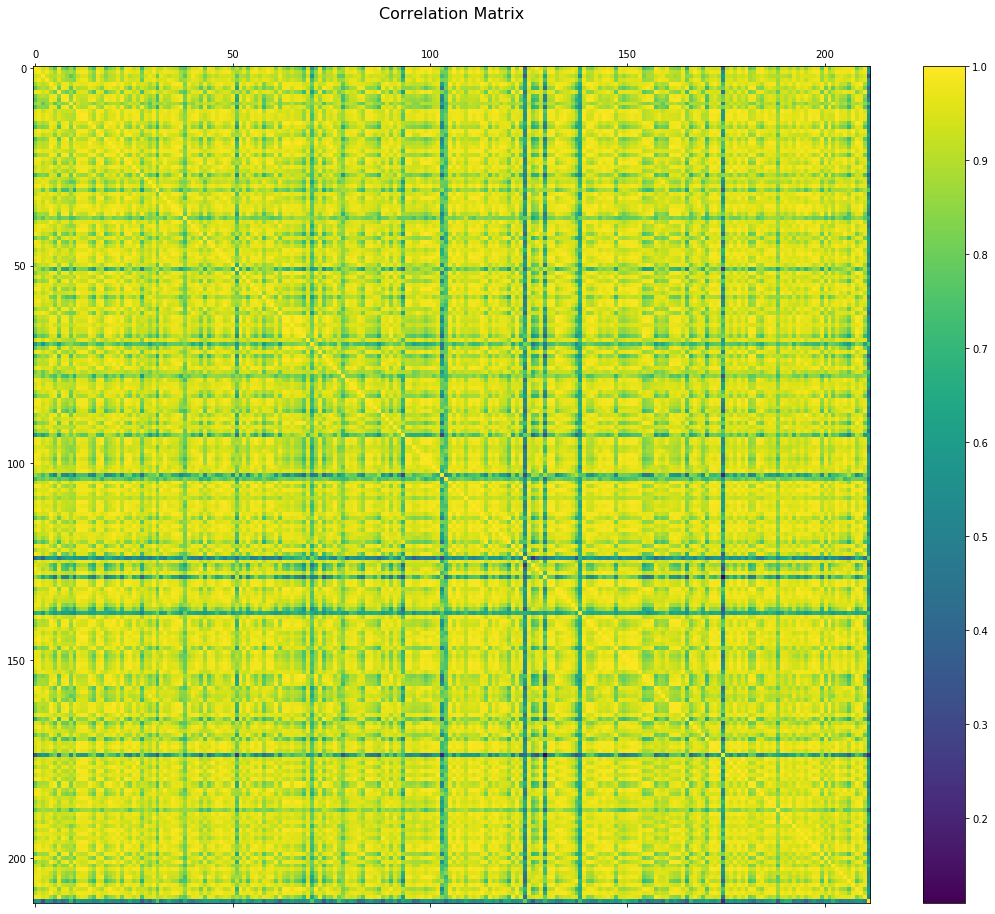

In [60]:
f = plt.figure(figsize=(19, 15))
plt.matshow(pivoted_GDP_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We then try to clusterize this correlation matrix in order to find countries whose GDP are correlated:

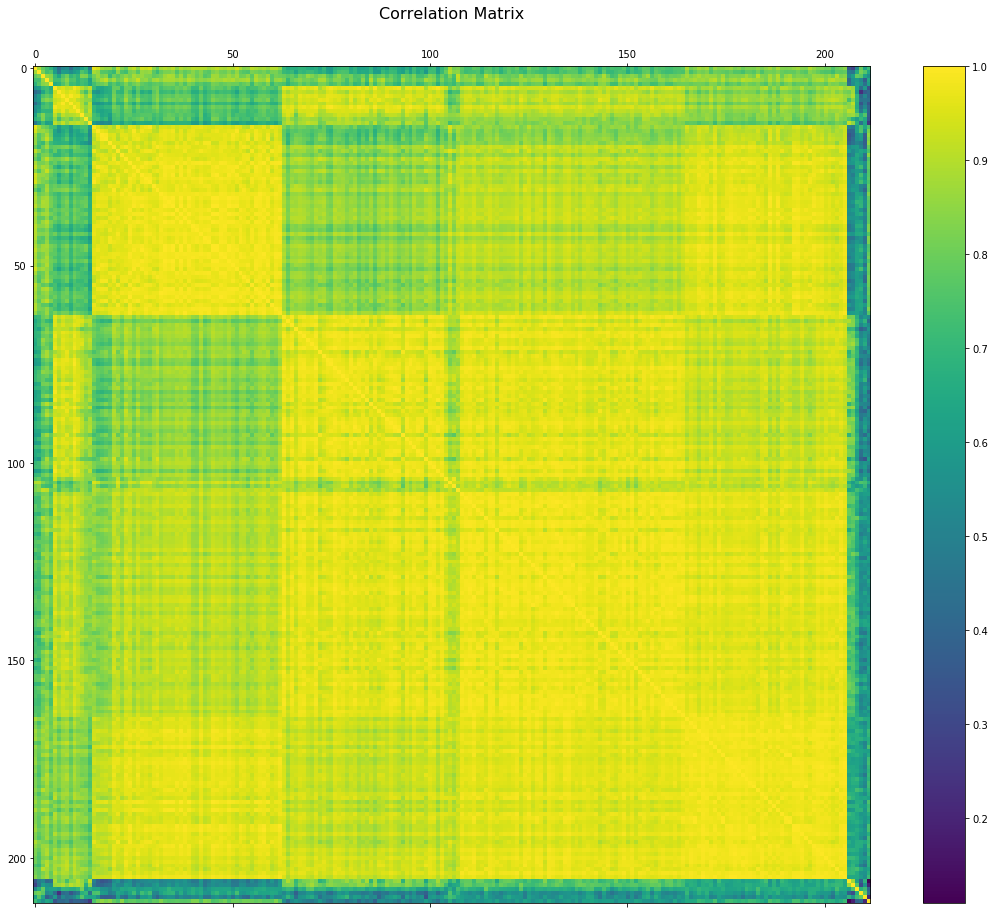

In [61]:
corr = pivoted_GDP_df.corr().values
pdist = spc.distance.pdist(corr)   # vector of ('55' choose 2) pairwise distances
linkage = spc.linkage(pdist, method='complete')
ind = spc.fcluster(linkage, 0.2*pdist.max(), 'distance')
columns = [pivoted_GDP_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
clusterised_df = pivoted_GDP_df.reindex(columns, axis=1)

f = plt.figure(figsize=(19, 15))
plt.matshow(clusterised_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We have found regions in which the GDP is highly correlated and between which the correlation coefficent is lower. We could refine the big clusters by iterating this method.

**Interpretation:** The correlation matrix of GDP contains lots of values that are very closed to one. This means that GDP in two different countries have a trend to evolve the same way. Therefore, we can say that the world countries have strong enough trading relations to make the GDP evolve the same way. The fact that we have found some main clusters could be interpreted as regions in which the trading relations are more important.

#### 2.D. Economic classification of countries <a name="2D"></a>

In [62]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df["(GDP, million $)"]
for year in range(1980, 2015, 5):
    display(year, visualise_world_data_folium(plot, year, True))

C:\Users\Martin\.conda\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1980

1985

1990

1995

2000

2005

2010

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Analysis of food production and trade with GDP](#3C)
        
        1. [Correlation between production features and GDP](#3Ca)
        
        2. [Correlation between food trade features and GDP](#3Cb)
        
        3. [Machine learning model](#3Cc)  
        
            1. [Model - based on trade](#3Cci)  
        
            2. [Model - based on production](#3Ccii) 

    3. [Food prices stability and agricultural features](#3C)  
  

#### 3.A. Production and consumption of food from a time-space geography point of view <a name="3A"></a>

#### 3.B. Food self-sufficiency <a name="3B"></a>

#### 3.C. Analysis of food production and trade with GDP <a name="3C"></a>

##### 3.C.a. Food production and GDP <a name="3Ca"></a>

Out of the crops and the livestock produced, we will focus on the top 20 crops as well as top 20 livestock produced globally to be able to have a model with a reasonable amount of feautures. 

In [63]:
#Choose the top 20 crops produced in the world for the first model
crop_production_df= uni_df.filter(like='Crops Production tonnes') 
crop_production_df = crop_production_df.sum(axis=0).sort_values(ascending=False)
crop_production_list = crop_production_df.index.tolist()[:20]
crop_production_list.insert(0,'(GDP, million $)')
crop_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
maincrops_df = uni_df[crop_production_list]

#Livestock
livestock_production_df= uni_df.filter(like='Livestock production') 
livestock_production_df = livestock_production_df.sum(axis=0).sort_values(ascending=False)
livestock_production_list = livestock_production_df.index.tolist()[:20]
livestock_production_list.insert(0,'(GDP, million $)')
livestock_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
mainlivestock_df = uni_df[livestock_production_list]

top_production_list = crop_production_list +livestock_production_list[1:]

top_production_df = uni_df[top_production_list]
top_production_df.head(5)

(GDP, million $)  Cereals (Rice Milled Eqv) Crops Production tonnes  \
0       1748.886597                                          3390122.0   
1       1831.108982                                          3202450.0   
2       1595.555482                                          3816800.0   
3       1733.333275                                          4130140.0   
4       2155.555500                                          4211140.0   

   Sugar cane Crops Production tonnes  \
0                             55000.0   
1                             50000.0   
2                             35000.0   
3                             58000.0   
4                             51600.0   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        144000.0   
1                                        167000.0   
2                                        158000.0   
3                                        165000.0   
4                                        182000.0   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          482000.0   
1                                          558000.0   
2                                          500000.0   
3                                          515000.0   
4                                          518000.0   

   Rice, paddy Crops Production tonnes  Maize Crops Production tonnes  \
0                             366000.0                       667000.0   
1                             350000.0                       670000.0   
2                             400000.0                       720000.0   
3                             420000.0                       760000.0   
4                             420000.0                       770000.0   

   Wheat Crops Production tonnes  \
0                      2081000.0   
1                      1915000.0   
2                      2450000.0   
3                      2700000.0   
4                      2750000.0   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         794600.0   
1                                         634800.0   
2                                         781400.0   
3                                         822500.0   
4                                         847500.0   

   Potatoes Crops Production tonnes  ...  Camels Livestock production Head  \
0                          144000.0  ...                          300000.0   
1                          167000.0  ...                          300000.0   
2                          158000.0  ...                          300000.0   
3                          165000.0  ...                          300000.0   
4                          182000.0  ...                          300000.0   

   Poultry Birds Livestock production 1000 Head  \
0                                        6000.0   
1                                        6000.0   
2                                        6000.0   
3                                        6100.0   
4                                        6100.0   

   Mules Livestock production Head  Chickens Livestock production 1000 Head  \
0                          35000.0                                   6000.0   
1                          35000.0                                   6000.0   
2                          31000.0                                   6000.0   
3                          26500.0                                   6100.0   
4                          26500.0                                   6100.0   

   Camelids, other Livestock production Head  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   Animals live nes Livestock production Head  \
0                                         0.0   
1                                         

In [64]:
#Checking correlations of main crops between each other and with GDP
mainprod_correlation_matrix = round (top_production_df.corr(method='pearson'),3)
mainprod_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)



(GDP, million $)                                         1.000
Maize Crops Production tonnes                            0.850
Tomatoes Crops Production tonnes                         0.840
Chickens Livestock production 1000 Head                  0.839
Poultry Birds Livestock production 1000 Head             0.836
Cereals (Rice Milled Eqv) Crops Production tonnes        0.817
Citrus Fruit,Total Crops Production tonnes               0.813
Fruit excl Melons,Total Crops Production tonnes          0.808
Wheat Crops Production tonnes                            0.796
Soybeans Crops Production tonnes                         0.757
Turkeys Livestock production 1000 Head                   0.754
Vegetables&Melons, Total Crops Production tonnes         0.747
Pigs Livestock production Head                           0.717
Bananas Crops Production tonnes                          0.708
Potatoes Crops Production tonnes                         0.707
Grapes Crops Production tonnes                         

Because "Cereals (Rice Milled Eqv) Crops Production tonnes" has such a high correlation with a lot of other features, it is probably an aggregate of them (eg over 90% with wheat).

C:\Users\Martin\.conda\envs\ada\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


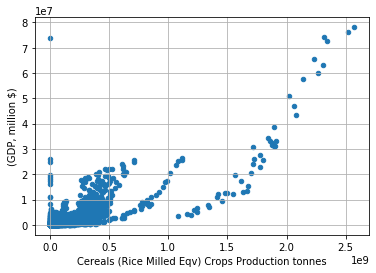

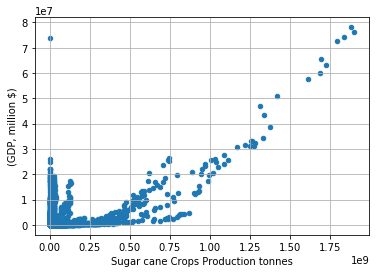

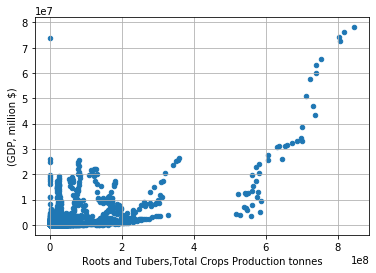

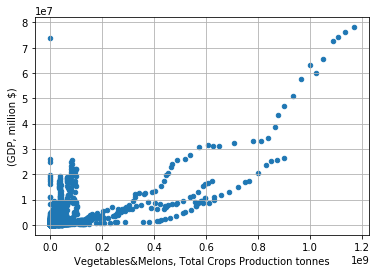

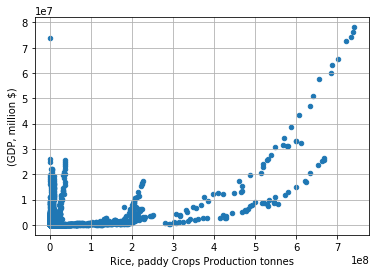

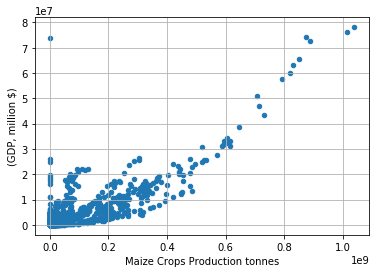

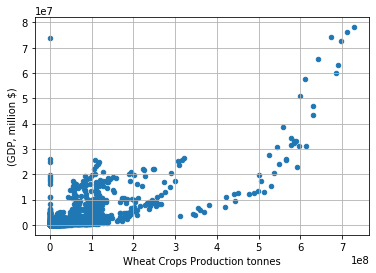

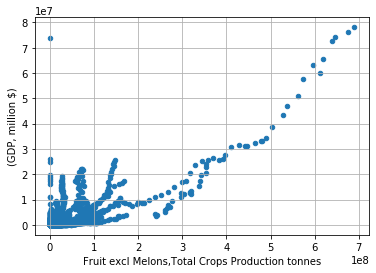

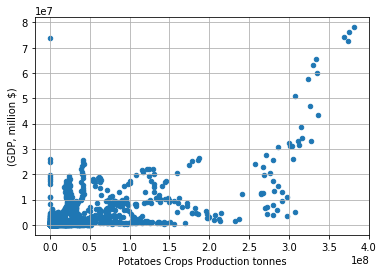

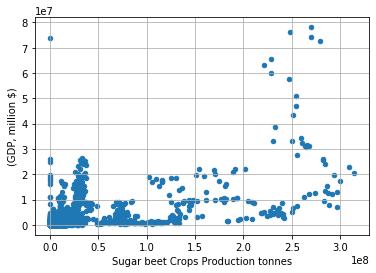

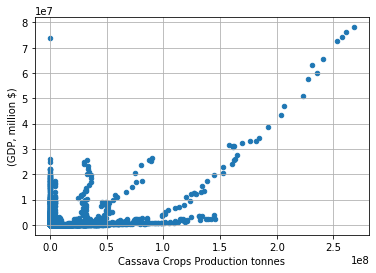

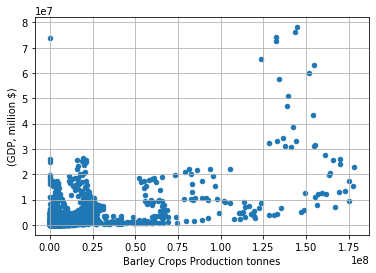

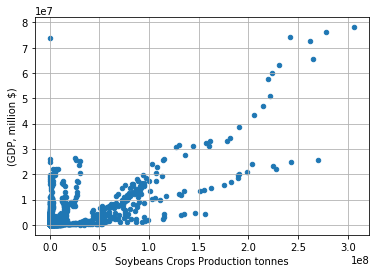

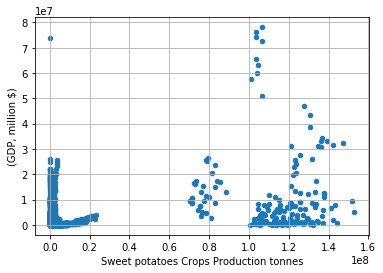

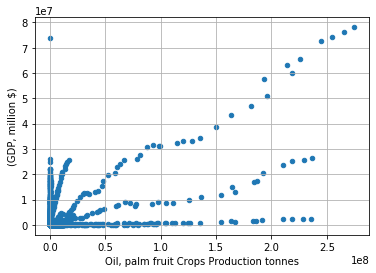

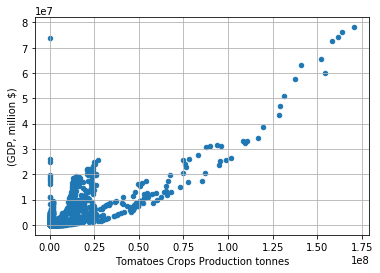

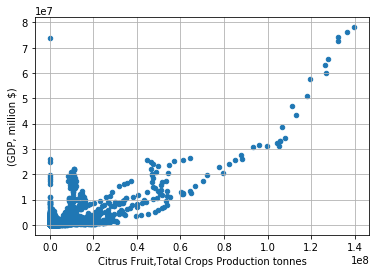

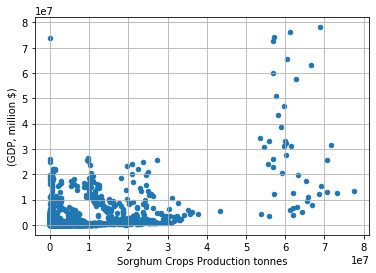

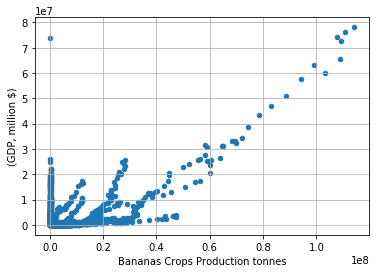

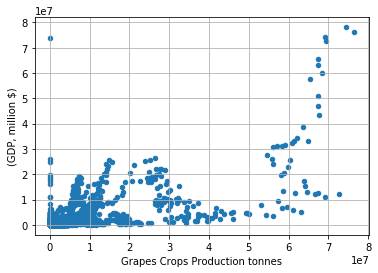

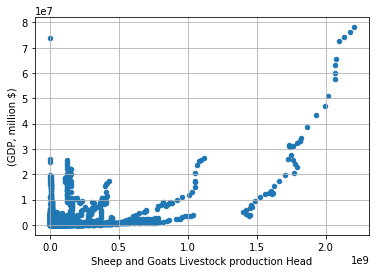

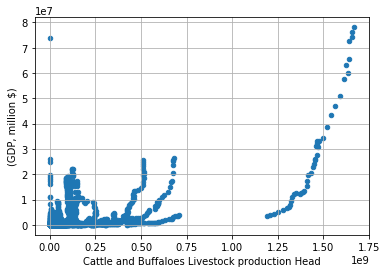

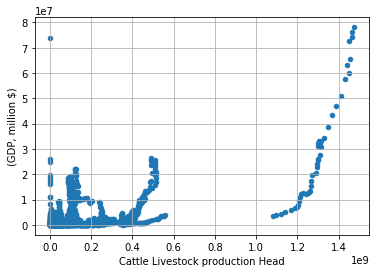

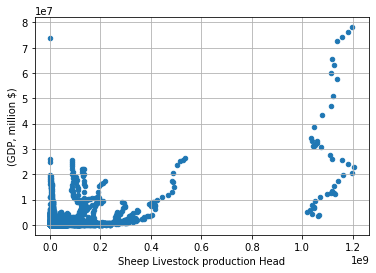

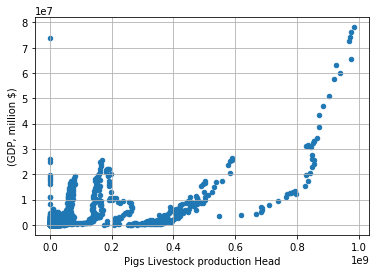

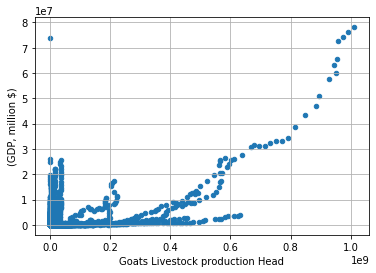

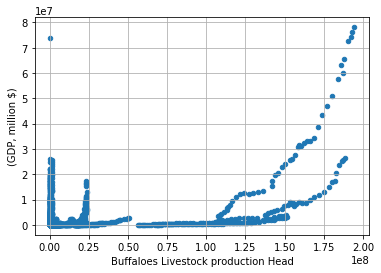

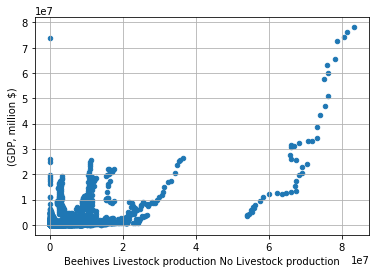

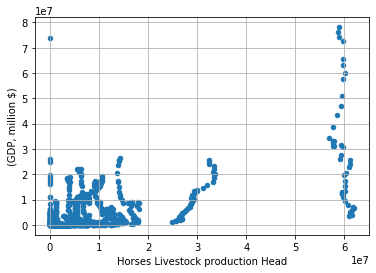

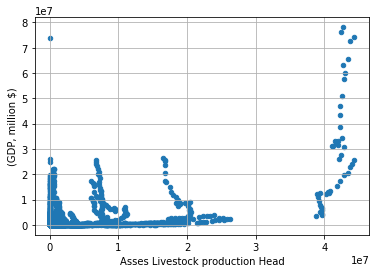

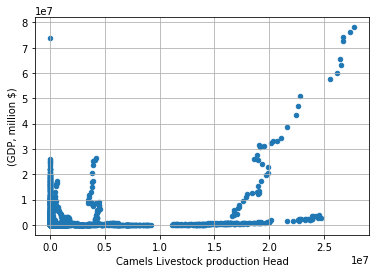

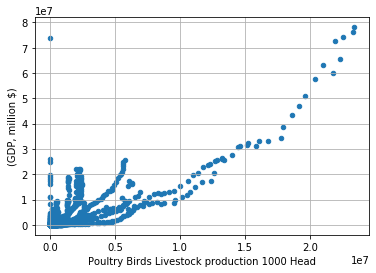

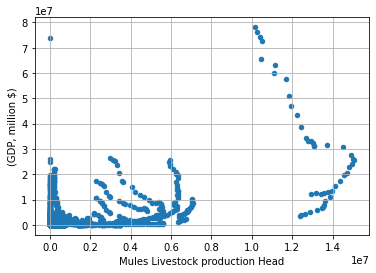

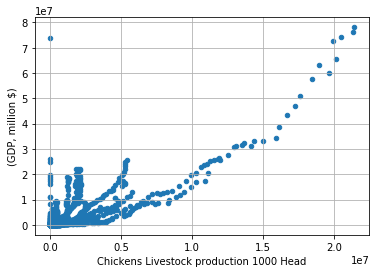

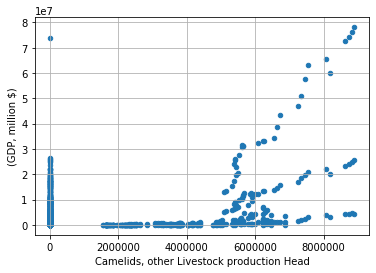

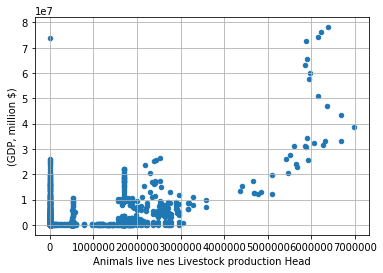

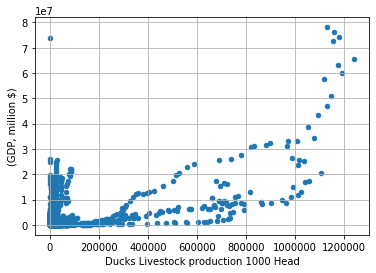

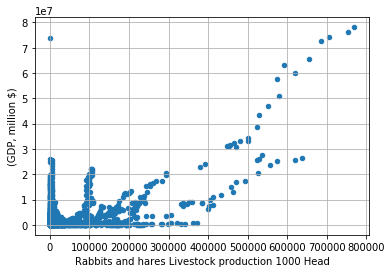

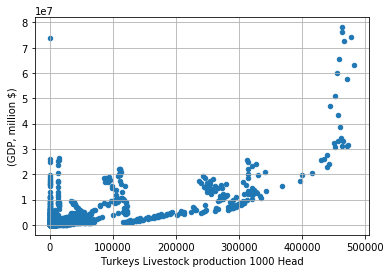

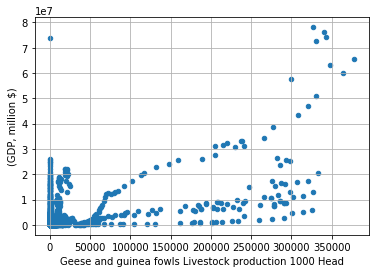

In [65]:
#Looking at some relationships
for item in list(top_production_df.columns)[1:]:
    top_production_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


We can quite clearly see that the production of many of the most popular crops can well be related to GDP.

##### 3.C.b. Trade and GDP <a name="3Cb"></a>

Let's see if the same can be said about the most exported/imported goods.

In [66]:
#Choose the top 20 most exported items by mass
top_exports_df= uni_df.filter(like='export quantities tonnes')
top_exports_df = top_exports_df.sum(axis=0).sort_values(ascending=False)
top_exports_list =top_exports_df.index.tolist()[:20]
top_exports_list

#Take the top 20 exported crops and the columns of our uni_df which contain their production
top_exports_list.insert(0,'(GDP, million $)')
top_exports_df = uni_df[top_exports_list]


#Choose the top 20 most imported items by mass
top_imports_df= uni_df.filter(like='import quantities tonnes')
top_imports_df = top_imports_df.sum(axis=0).sort_values(ascending=False)

top_imports_list =top_imports_df.index.tolist()[:20]
top_imports_list

#Take the top 20 imported items and the columns of our uni_df which contain their production
top_imports_list.insert(0,'(GDP, million $)')
top_imports_df = uni_df[top_imports_list]

#Create a joined list
top_traded_list = top_exports_list +top_imports_list[1:]

In [67]:

top_traded_df = uni_df[top_traded_list]
top_traded_df.head(5)

(GDP, million $)  Cereals Food export quantities tonnes  \
0       1748.886597                                    0.0   
1       1831.108982                                    0.0   
2       1595.555482                                    0.0   
3       1733.333275                                    0.0   
4       2155.555500                                    0.0   

   Wheat+Flour,Wheat Equivalent Food export quantities tonnes  \
0                                                0.0            
1                                                0.0            
2                                                0.0            
3                                                0.0            
4                                                0.0            

   Wheat Food export quantities tonnes  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   

   Fodder & Feeding stuff Food export quantities tonnes  \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                                0.0      
4                                                0.0      

   Maize Food export quantities tonnes  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   

   Milk Equivalent Food export quantities tonnes  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Oilseeds Food export quantities tonnes  \
0                                  7229.0   
1                                  3456.0   
2                                 34541.0   
3                                 27678.0   
4                                 18490.0   

   Sugar and Honey Food export quantities tonnes  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Oilseed Cake Meal Food export quantities tonnes  ...  \
0                                              0.0  ...   
1                                              0.0  ...   
2                                              0.0  ...   
3                                              0.0  ...   
4                                              0.0  ...   

   Animal Vegetable Oil Food import quantities tonnes  \
0                                             8286.0    
1                                            11763.0    
2                                            14471.0    
3                                            10279.0    
4                                            11017.0    

   Sugar,Total (Raw Equiv.) Food import quantities tonnes  \
0                                            57611.0        
1                                            49413.0        
2                                            46332.0        
3                                            60959.0        
4                                            54024.0        

   Beverages Food import quantities tonnes  \
0                                     12.0   
1                                     20.0   
2                                      0.0   
3                                     12.0   
4                                     11.0   

   Cake, soybeans Food import quantities tonnes  \
0                                           0.0   
1                                    

In [68]:
#Checking correlations of main traded goods between each other and with GDP
top_traded_correlation_matrix = round (top_traded_df.corr(method='pearson'),3)
top_traded_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)


(GDP, million $)                                                        1.000
Total Meat Food export quantities tonnes                                0.841
Animal Vegetable Oil Food import quantities tonnes                      0.827
Fodder & Feeding stuff Food export quantities tonnes                    0.825
Fixed Vegetable Oils Food import quantities tonnes                      0.819
Sugar and Honey Food import quantities tonnes                           0.796
Fodder & Feeding stuff Food import quantities tonnes                    0.790
Cake, soybeans Food import quantities tonnes                            0.785
Milk Equivalent Food import quantities tonnes                           0.784
Oilseed Cake Meal Food import quantities tonnes                         0.783
Oilseeds Food import quantities tonnes                                  0.779
Cereals Food export quantities tonnes                                   0.776
Wheat+Flour,Wheat Equivalent Food export quantities tonnes      

It seems that the most high correlations can be found from  exports of meat as well as feeding stuff. 

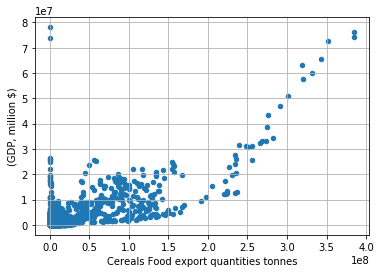

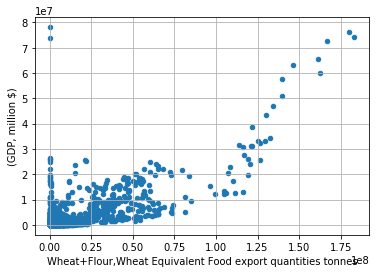

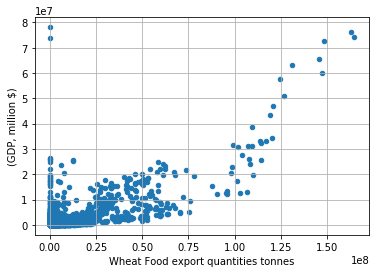

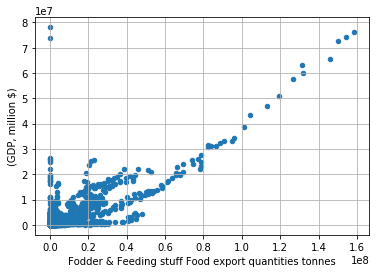

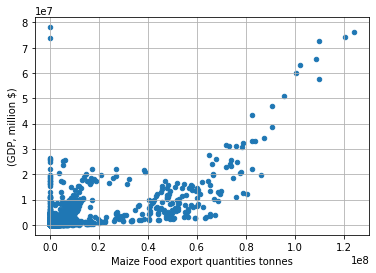

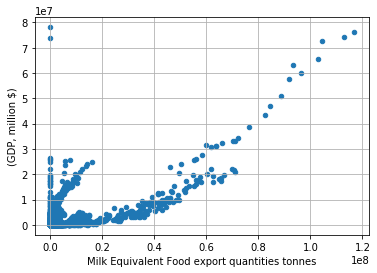

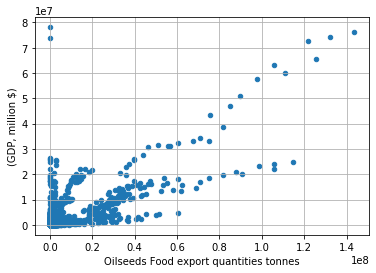

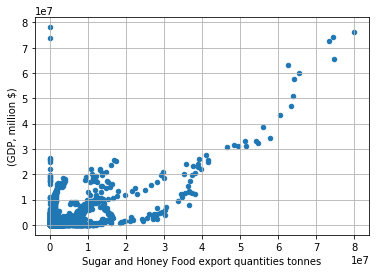

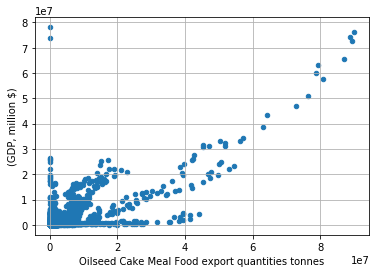

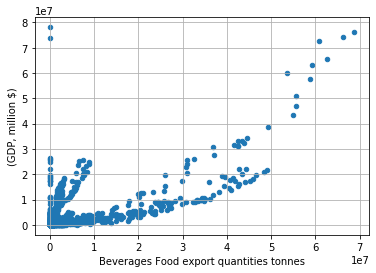

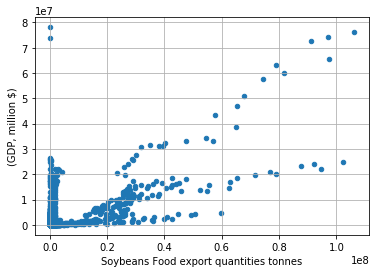

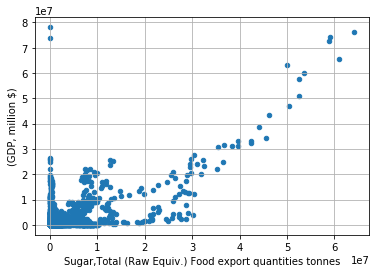

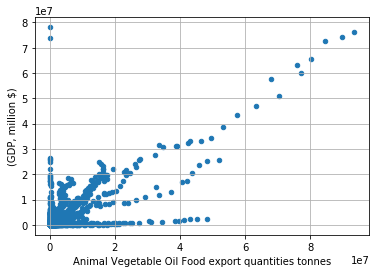

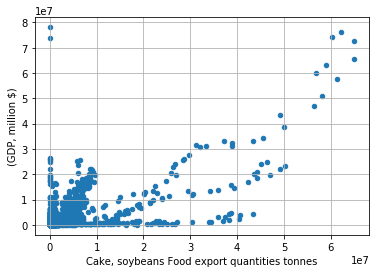

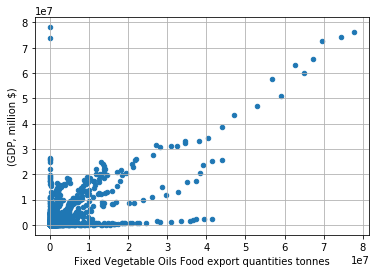

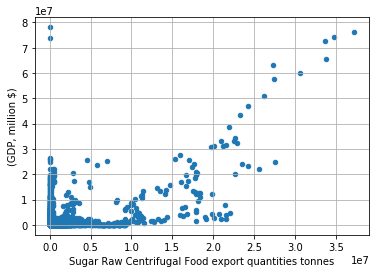

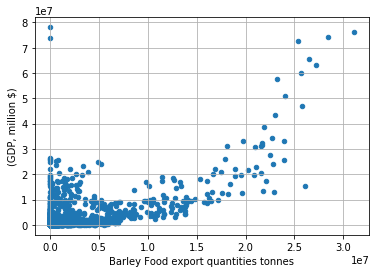

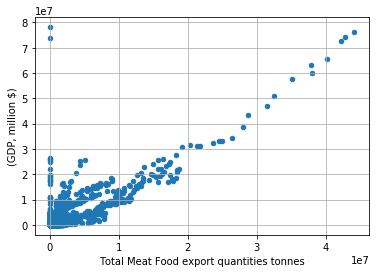

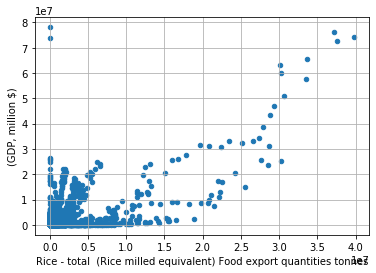

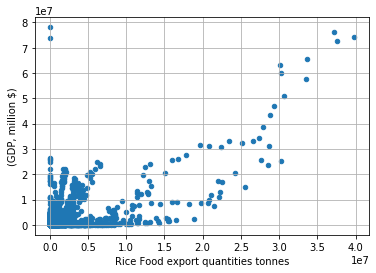

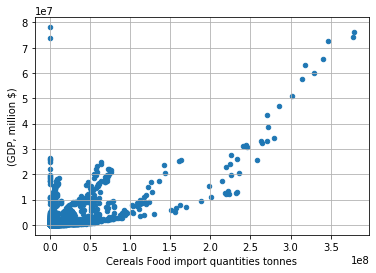

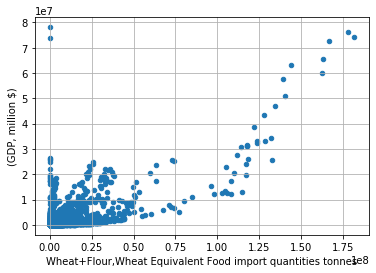

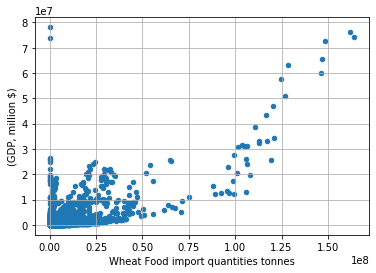

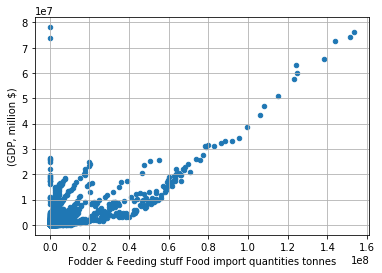

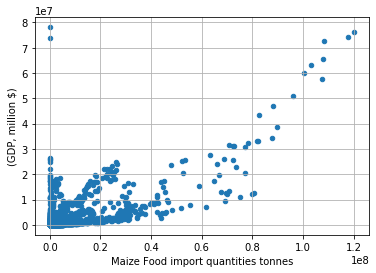

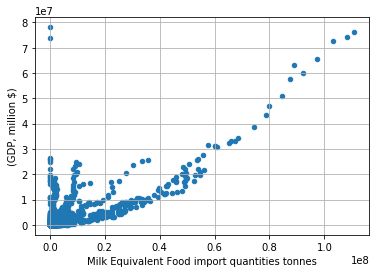

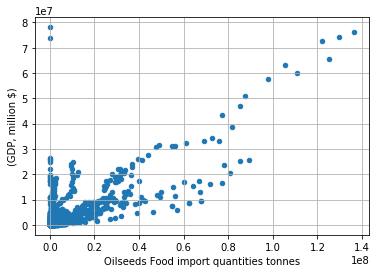

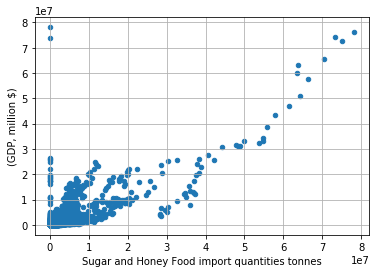

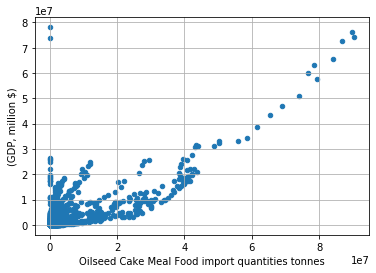

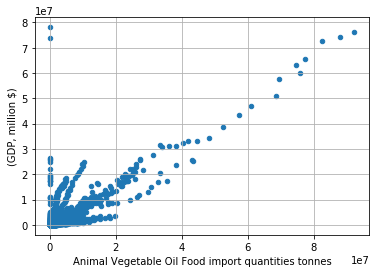

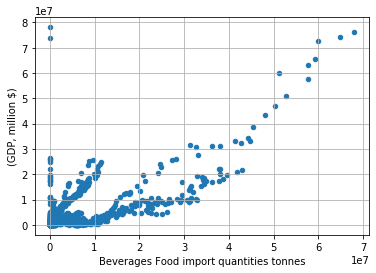

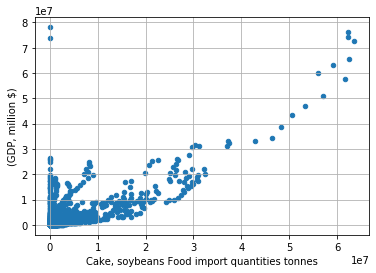

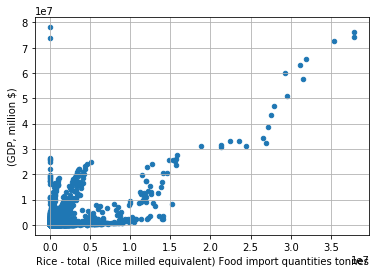

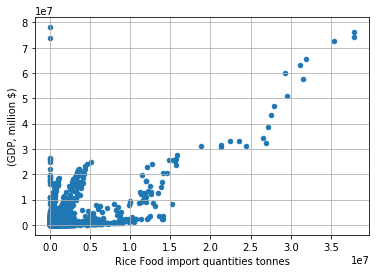

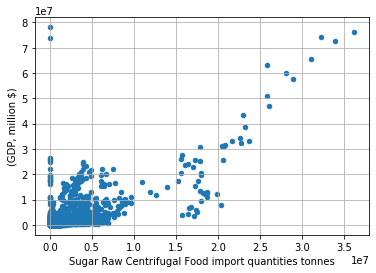

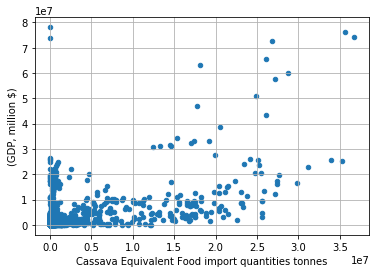

In [69]:
#Looking at some relationships
for item in list(top_traded_df.columns)[1:]:
    top_traded_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


##### 3.C.c. Machine learning model <a name="3Cc"></a>

###### 3.C.c.i. Model - based on production <a name="3Cci"></a>

First, we only create a model using the production data. Afterwards, we use the data on exports, imports. 

#### Standardization, scaling


Clearly seeing that our data isn't normally distributed, this means we shouldn't use standardization. We'll use a min-max scaling to make different quantities comparable in the same model. 

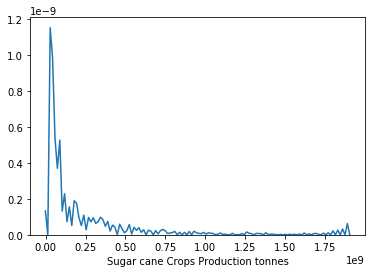

In [70]:
sns.distplot(maincrops_df["Sugar cane Crops Production tonnes"], rug=False, hist=False)

C:\Users\Martin\.conda\envs\ada\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


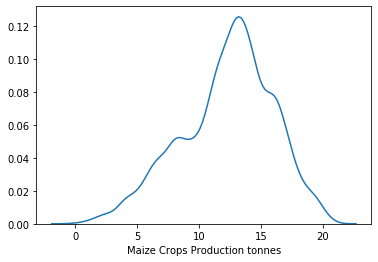

In [71]:
sns.distplot(np.log(maincrops_df["Maize Crops Production tonnes"]), rug=False, hist=False)

We can clearly see that the production is not normally distributed, thus we shouldn't use a normalization of our features.
The huge peak is probably from all the Nan values we set to the median...

In [72]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_production_values = top_production_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_production_minmaxed_values = min_max_scaler.fit_transform(top_production_values)
top_production_minmaxed = pd.DataFrame(top_production_minmaxed_values, columns=top_production_df.columns)
top_production_minmaxed.head(5)

(GDP, million $)  Cereals (Rice Milled Eqv) Crops Production tonnes  \
0          0.000022                                           0.001318   
1          0.000023                                           0.001245   
2          0.000020                                           0.001484   
3          0.000022                                           0.001606   
4          0.000028                                           0.001638   

   Sugar cane Crops Production tonnes  \
0                            0.000029   
1                            0.000026   
2                            0.000018   
3                            0.000030   
4                            0.000027   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        0.000170   
1                                        0.000198   
2                                        0.000187   
3                                        0.000195   
4                                        0.000215   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          0.000412   
1                                          0.000477   
2                                          0.000428   
3                                          0.000440   
4                                          0.000443   

   Rice, paddy Crops Production tonnes  Maize Crops Production tonnes  \
0                             0.000494                       0.000643   
1                             0.000472                       0.000646   
2                             0.000539                       0.000694   
3                             0.000566                       0.000732   
4                             0.000566                       0.000742   

   Wheat Crops Production tonnes  \
0                       0.002855   
1                       0.002627   
2                       0.003361   
3                       0.003704   
4                       0.003772   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         0.001153   
1                                         0.000921   
2                                         0.001133   
3                                         0.001193   
4                                         0.001229   

   Potatoes Crops Production tonnes  ...  Camels Livestock production Head  \
0                          0.000377  ...                          0.010816   
1                          0.000438  ...                          0.010816   
2                          0.000414  ...                          0.010816   
3                          0.000432  ...                          0.010816   
4                          0.000477  ...                          0.010816   

   Poultry Birds Livestock production 1000 Head  \
0                                      0.000257   
1                                      0.000257   
2                                      0.000257   
3                                      0.000261   
4                                      0.000261   

   Mules Livestock production Head  Chickens Livestock production 1000 Head  \
0                         0.002322                                 0.000280   
1                         0.002322                                 0.000280   
2                         0.002057                                 0.000280   
3                         0.001758                                 0.000285   
4                         0.001758                                 0.000285   

   Camelids, other Livestock production Head  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   Animals live nes Livestock production Head  \
0                                         0.0   
1                                         

In [73]:
train_set, test_set = train_test_split(top_production_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

In [74]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]C:\Users\Martin\.conda\envs\ada\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.82034e-19): result may not be accurate.
  overwrite_a=True).T
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:21<00:00, 18.62it/s]


The best value obtained is for alpha equal to 0.0 with a MSE of 0.00015811942461140845


In [75]:
#this means I choose my alpha as 0??
# We build our model with the chosen alpha.
model_top_production = Ridge(alpha=0)
model_top_production.fit(X_train_set, Y_train_set)



Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [76]:
weights_top_production = pd.DataFrame([model_top_production.coef_], columns=top_production_df.columns[1:])
weights_top_production = weights_top_production.sort_values(by=0, axis=1, ascending=False)                                  
weights_top_production

Cattle and Buffaloes Livestock production Head  \
0                                    2.666152e+12   

   Sheep and Goats Livestock production Head  \
0                               4.098203e+07   

   Chickens Livestock production 1000 Head  \
0                                16.674787   

   Ducks Livestock production 1000 Head  \
0                              0.772036   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         0.726204   

   Wheat Crops Production tonnes  Maize Crops Production tonnes  \
0                       0.451706                       0.441653   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        0.341977   

   Turkeys Livestock production 1000 Head  Sugar beet Crops Production tonnes  \
0                                0.270838                            0.209655   

   ...  Cassava Crops Production tonnes  Rice, paddy Crops Production tonnes  \
0  ...                        -0.145715                            -0.171908   

   Citrus Fruit,Total Crops Production tonnes  \
0                                    -0.18528   

   Sorghum Crops Production tonnes  Potatoes Crops Production tonnes  \
0                        -0.206086                         -0.584383   

   Poultry Birds Livestock production 1000 Head  \
0                                    -17.719031   

   Goats Livestock production Head  Sheep Livestock production Head  \
0                    -1.877910e+07                    -2.238775e+07   

   Buffaloes Livestock production Head  Cattle Livestock production Head  
0                        -3.106488e+11                     -2.355503e+12  

[1 rows x 40 columns]

In [77]:
model_top_production.score(X_train_set, Y_train_set)

0.9061801590470477

The result doesn't seem to make sense!! probably because chickens and poultry are so highly correlated. 

###### 3.C.c.ii. Model - based on trade <a name="3Ccii"></a>

In [78]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_traded_values = top_traded_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_traded_minmaxed_values = min_max_scaler.fit_transform(top_traded_values)
top_traded_minmaxed = pd.DataFrame(top_traded_minmaxed_values, columns=top_traded_df.columns)
top_traded_minmaxed.head(5)

(GDP, million $)  Cereals Food export quantities tonnes  \
0          0.000022                                    0.0   
1          0.000023                                    0.0   
2          0.000020                                    0.0   
3          0.000022                                    0.0   
4          0.000028                                    0.0   

   Wheat+Flour,Wheat Equivalent Food export quantities tonnes  \
0                                                0.0            
1                                                0.0            
2                                                0.0            
3                                                0.0            
4                                                0.0            

   Wheat Food export quantities tonnes  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   

   Fodder & Feeding stuff Food export quantities tonnes  \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                                0.0      
4                                                0.0      

   Maize Food export quantities tonnes  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   

   Milk Equivalent Food export quantities tonnes  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Oilseeds Food export quantities tonnes  \
0                                0.000050   
1                                0.000024   
2                                0.000241   
3                                0.000193   
4                                0.000129   

   Sugar and Honey Food export quantities tonnes  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Oilseed Cake Meal Food export quantities tonnes  ...  \
0                                              0.0  ...   
1                                              0.0  ...   
2                                              0.0  ...   
3                                              0.0  ...   
4                                              0.0  ...   

   Animal Vegetable Oil Food import quantities tonnes  \
0                                           0.000090    
1                                           0.000127    
2                                           0.000157    
3                                           0.000111    
4                                           0.000119    

   Sugar,Total (Raw Equiv.) Food import quantities tonnes  \
0                                           0.000954        
1                                           0.000818        
2                                           0.000767        
3                                           0.001009        
4                                           0.000894        

   Beverages Food import quantities tonnes  \
0                             1.764093e-07   
1                             2.940155e-07   
2                             0.000000e+00   
3                             1.764093e-07   
4                             1.617085e-07   

   Cake, soybeans Food import quantities tonnes  \
0                                           0.0   
1                                    

In [79]:
train_set, test_set = train_test_split(top_traded_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

In [ ]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 392/400 [00:20<00:00, 20.17it/s]

In [ ]:
# We build our model with the chosen alpha.
model_trade = Ridge(alpha=0)
model_trade.fit(X_train_set, Y_train_set)



In [ ]:
weights_trade = pd.DataFrame([model_trade.coef_], columns=top_traded_minmaxed.columns[1:])
weights_trade = weights_trade.sort_values(by=0, axis=1, ascending=False)                                  
weights_trade

In [ ]:
model_trade.score(X_train_set, Y_train_set)

This needs to be cleaned, bc obviously the one with highest and lowest weights are actually super related.

#### 3.D. Food prices stability and agricultural features <a name="3D"></a>

### 4. Informed plan for next actions  <a name="4"></a>

Our results seem pretty intersting to share to the world. Moreover we have nice interactive maps and we would like to focus more on visual and style than writting on methodology. Therefore, we would like to produce a data story.
